# Perfil comercial de um país

Este notebook reúne dados de um perfil comercial de um país. Os dados são obtidos da API da UN Comtrade.

Para um país e período de interesse (em um intervalo de anos) ele fornece:

1. Evolução da balança comercial (Importações e Exportações), comparando valor declarado e valor de comércio simétrico
   (e.g. valor de exportações por agregação de importações de outros países, e valor de importações por agregação de exportações de outros países)
   * Exportado para o ficheiro "reports/[PAIS]_trade_balance_2003-2023.xlsx", e gráfico em "reports/<PAÍS>_trade_balance_2003-2023.png" por exº:
   [reports/Angola_trade_balance_2003-2023.xlsx](reports/Angola_trade_balance_2003-2023.xlsx) e [reports/Angola_trade_balance_2003-2023.png](reports/Angola_trade_balance_2003-2023.png)
2. Principais parcerios comerciais (exportações e importações). Inclui:
   1.Exportações: valor das exportações para os países nos cinco (configurável) primeiros parceiros em qualquer um dos anos do período em análise. Por cada país parceiro, é indicado o valor total de exportações no período e a percentagem no total das exportações de cada ano em análise. Os valor das exportações é baseado nas importações reportadas pelos parceiros (é possível 
   usar em alternativa os valores reportados de exportação do país em análise).
   2. Com base nestes dados são produzidos os seguintes ficheiros:
      * "reports/[PAIS]_top_export_partners.xlsx": dados retirados da API da UN Comtrade para os anos de 2003 a 2023 uma linha por combinação PAIS-PARCEIRO-ANO.
      * "reports/[PAIS]_top_export_partners_cols.xlsx": quadro simplicado com os anos em linhas e os parceiros em colunas. Por cada parceiro duas colunas: valor de exportações e percentagem no total das exportações do ano.
      * "reports/[PAIS]_export_top_5_partners_2003-2023.xlsx" versão simplificada do ficheiro anterior, apenas com os países que foram um dos cinco principais parceiros em qualquer um dos anos.
      * Um gráfico com a evolução das trocas com os principais países "reports/<PAÍS>_export_partners_2003-2023.png", por exº: [reports/Angola_export_partners_2003-2023.png](reports/Angola_export_partners_2003-2023.png)
3. Principais produtos exportados. Inclui
   1. Produtos: valor das exportações dos produtos nos cinco (configurável) produtos mais exportados em qualquer um dos anos do período em análise. O valor das exportações é baseado nas importações reportadas pelos parceiros (é possível usar em alternativa os valores reportados de exportação do país em análise)。 Os valores reportados são agregados por HS-AG6 (nível
   de detalhe de 6 dígitos, como nas fichas do Banco Mundial, configurável). Depois de agregados, são identificados os cinco produtos mais exportados em qualquer um dos anos do período em análise. Por cada produto, é indicado o valor total de exportações no período e a percentagem no total das exportações de cada ano em análise.
      * "reports/[PAIS]_exports_products_HS-AG6-2003-2023.xlsx" 
   2. Principais destinos dos principais produtos. Por cada ano, são identificados os cinco principais destinos dos cinco produtos mais exportados. Para cada produto, é indicado o valor total de exportações das exportações para os cinco (configurável) principais compradores e a percentagem de cada parceiro no total das exportações desse produto desse ano. Estes dados
   permitem analisar a evolução dos destinos dos principais produtos exportados.
      * "reports/[PAIS]_exports_partners_HS-AG6-2003-2023.xlsx"
   3. Fornecedores alternativos para os principais produtos. Por cada país parceiro que importa um dos produtos mais exportados são obtidos
         os fornecedores alternativos do parceiro para esse produto, e calculado o ranking do país em análise dentro do conjunto de fornecedores. Estes dados permitem
         analisar a importância do país em análise como fonte de fornecimento para os parceiros comerciais.
         *"reports/[PAIS]_export_partners_alternative.xlsx"


## Setup

For instructions and how to obtain an API key, see [here](0-comtrade-setup-first.ipynb).

In [1]:
import comtradetools as comtradetools

comtradetools.setup()
APIKEY = comtradetools.get_api_key()
comtradetools.init(APIKEY, force_init=False)

INFO:root:Loading HS codes from support/harmonized-system.csv


## Country and period of interest

Choose country and years of interest

In [2]:
import comtradetools


country_of_interest_name = 'Angola'
country_of_interest = comtradetools.encode_country(country_of_interest_name)

years_of_interest=comtradetools.year_range(2003,2023)
print(country_of_interest_name, years_of_interest)

Angola 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


## Trade balance

In [3]:
import comtradetools
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.2f}'.format

periods = comtradetools.split_period(years_of_interest,6)
global_trade = pd.DataFrame()
for period in periods:
    print(f"Fetching data for period {period}")

    temp = comtradetools.get_trade_flows(country_of_interest,
                                            period=period,
                                            symmetric_values=True)

    global_trade = pd.concat([global_trade,temp])


global_trade = global_trade.replace(0, np.nan)
cols_of_interest = global_trade.columns



INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2009,2010,2011,2012,2013,2014
INFO:root:Using cached results for period 2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2009,2010,2011,2012,2013,2014
INFO:root:Using cached results for period 2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2009,2010,2011,2012,2013,2014
INFO:root:Using cached results for period 2009,2010,2011,2012,20

Fetching data for period 2003,2004,2005,2006,2007,2008
Fetching data for period 2009,2010,2011,2012,2013,2014
Fetching data for period 2015,2016,2017,2018,2019,2020
Fetching data for period 2021,2022,2023


In [4]:
global_trade['varM_perc']=global_trade['M']/global_trade['M<X']
global_trade['varX_perc']=global_trade['X']/global_trade['X<M']
print(f"M = Imports as reported by {country_of_interest_name}")
print(f"X = Exports as reported by {country_of_interest_name}")
print(f"X<M = Exports as reported by rest of the world imports from {country_of_interest_name}")
print(f"M<X = Imports as reported by rest of the world exports to {country_of_interest_name}")
global_trade


M = Imports as reported by Angola
X = Exports as reported by Angola
X<M = Exports as reported by rest of the world imports from Angola
M<X = Imports as reported by rest of the world exports to Angola


flowCode,M,M<X,X,X<M,trade_balance (X-M),trade_balance (X<M-M),trade_volume (X+M),trade_volume (X<M+M),varM_perc,varX_perc
period,,,,,,,,,,
2003,NaN,"4,431,063,866.32",NaN,"9,322,134,085.35",NaN,"9,322,134,085.35",NaN,"9,322,134,085.35",NaN,NaN
2004,NaN,"6,674,906,901.50",NaN,"12,774,810,411.91",NaN,"12,774,810,411.91",NaN,"12,774,810,411.91",NaN,NaN
2005,NaN,"7,767,184,001.86",NaN,"22,086,367,001.78",NaN,"22,086,367,001.78",NaN,"22,086,367,001.78",NaN,NaN
2006,NaN,"10,636,294,703.97",NaN,"32,047,827,417.37",NaN,"32,047,827,417.37",NaN,"32,047,827,417.37",NaN,NaN
2007,"11,094,843,413.00","12,662,439,392.45","44,177,783,071.00","41,711,887,538.55","33,082,939,658.00","30,617,044,125.55","55,272,626,484.00","52,806,730,951.55",0.88,1.06
2008,NaN,"20,453,103,082.93",NaN,"67,748,978,154.39",NaN,"67,748,978,154.39",NaN,"67,748,978,154.39",NaN,NaN
2009,"23,918,854,361.00","17,838,362,501.79","40,639,411,732.00","39,936,869,089.04","16,720,557,371.00","16,018,014,728.04","64,558,266,093.00","63,855,723,450.04",1.34,1.02
2010,"18,143,268,908.00","15,870,330,898.55","52,612,114,761.00","53,460,941,627.27","34,468,845,853.00","35,317,672,719.27","70,755,383,669.00","71,604,210,535.27",1.14,0.98
2011,"20,790,996,039.00","18,333,349,046.96","66,427,390,220.00","66,207,593,128.22","45,636,394,181.00","45,416,597,089.22","87,218,386,259.00","86,998,589,167.22",1.13,1.00


Save to Excel file

In [5]:
start_year=global_trade.index.min()
end_year=global_trade.index.max()
excel_file = f"reports/{country_of_interest_name}_trade_balance_{start_year}-{end_year}.xlsx"
global_trade.to_excel(excel_file)
print("Trade ballance report saved to ", excel_file)

Trade ballance report saved to  reports/Angola_trade_balance_2003-2023.xlsx


## Show graph of trade balanace

Plot saved to  reports/Angola_trade_balance_2003-2023.png
0 Line2D(M) 0.0
1 Line2D(M<X) 0.8
2 Line2D(X) 0.0
3 Line2D(X<M) 0.8
4 Line2D(trade_balance (X-M)) 0.0
5 Line2D(trade_balance (X<M-M)) 0.8
6 Line2D(trade_volume (X+M)) 0.0
7 Line2D(trade_volume (X<M+M)) 0.8


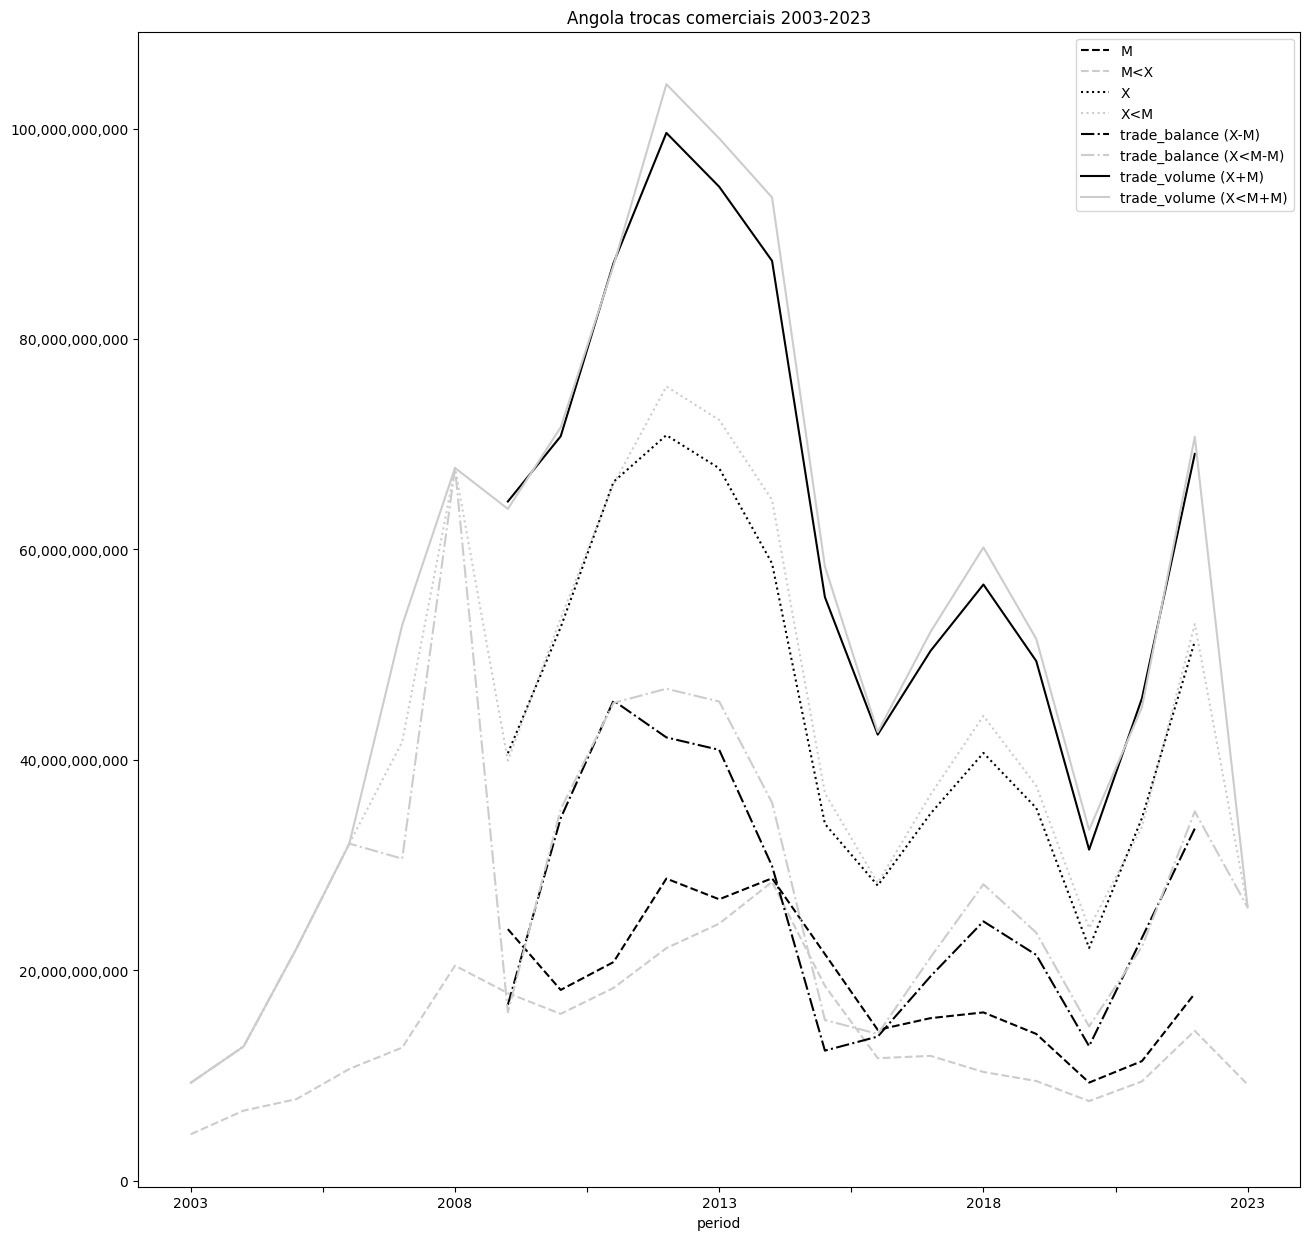

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

start_year=global_trade.index.min()
end_year=global_trade.index.max()
title=f"{country_of_interest_name} trocas comerciais {start_year}-{end_year}"
plotfile = f"reports/{country_of_interest_name}_trade_balance_{start_year}-{end_year}.png"
print("Plot saved to ", plotfile)
fig = global_trade[cols_of_interest].plot.line(figsize=(15,15),title=title)

# use a grayscale palette of colors
colors = ['0.0','0.8','0.0','0.8','0.0','0.8','0.0','0.8']

# use different line styles and black lines
linestyles = ['dashed', 'dashed', 'dotted', 'dotted', 'dashdot', 'dashdot', 'solid', 'solid']
for i, line in enumerate(fig.get_lines()):
    print(i, line, colors[i])
    line.set_color(colors[i])
    line.set_linestyle(linestyles[i % len(linestyles)])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig.yaxis.set_major_formatter(formatter)
fig.legend(list(global_trade.columns.astype(str)))

plt.savefig(plotfile)
plt.show()

## Exports


### Main export partners

Colect destinations of exports of the country. 

Use either reported exports
of country of interest, or reported imports from country of interest by
all other countries (symmetric reporting). 

Set variable `symmetric_reporting` to choose.

In [7]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = True  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'


In [8]:

# years_of_interest = comtrade.year_range(2020, 2021)
df = comtradetools.getFinalData(APIKEY,
                                reporterCode=reporterCode,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode=flowCode,
                                period=years_of_interest,
                                partnerCode=partnerCode,
                                remove_world=True,
                                partner2Code=0,  # world
                                clCode="HS",
                                cmdCode="TOTAL",
                                motCode=0,  # all means of transport
                                customsCode='C00', # all customs
                                includeDesc=True,
                                cache=True
                                )

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020,2021,2022,2023
INFO:root:Using cached results for period 2015,2016,2017,2018,2019,2020,2021,2022,2023


Compute percentage o trade and rank of partners for each year.

Use `show_only_top` to show only the top partners (e.g. 5).

In [9]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5

# aggregate by year, flow, reporter
exports = comtradetools.total_rank_perc(df,groupby=['refYear','flowCode',f'{partner_column}Desc'],
                                    col='primaryValue',
                                    prefix='partner',
                                    drop_duplicates=True)

cols=['refYear','flowCode',f'{partner_column}Desc','cmdCode','partner_upper_sum','partner_sum','partner_rank','partner_perc','partner_upper_perc']

formats =  comtradetools.make_format(cols)

top_export_partners = exports[exports['partner_rank']<=show_only_top][f'{partner_column}Desc'].unique()
top_export_partners_codes = exports[exports['partner_rank']<=show_only_top][f'{partner_column}Code'].unique()

print(f"Top {show_only_top} export partners of {country_of_interest_name} in {years_of_interest}: \n{top_export_partners}")
exports[exports['partner_rank']<=show_only_top][cols].sort_values(['refYear','flowCode','partner_rank',f'{partner_column}Desc','cmdCode']).style.format(formats)

Top 5 export partners of Angola in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023: 
['China' 'France' 'Rep. of Korea' 'Other Asia, nes' 'USA' 'Chile'
 'South Africa' 'Canada' 'India' 'Portugal' 'Spain' 'United Arab Emirates'
 'Thailand' 'Netherlands']


,refYear,flowCode,reporterDesc,cmdCode,partner_upper_sum,partner_sum,partner_rank,partner_perc,partner_upper_perc
88,2003,M,USA,TOTAL,"$9,322,134,085","$4,508,909,969",1,48.368%,48.368%
10,2003,M,China,TOTAL,"$9,322,134,085","$2,205,934,880",2,23.663%,23.663%
50,2003,M,"Other Asia, nes",TOTAL,"$9,322,134,085","$754,817,300",3,8.097%,8.097%
25,2003,M,France,TOTAL,"$9,322,134,085","$693,959,478",4,7.444%,7.444%
42,2003,M,Rep. of Korea,TOTAL,"$9,322,134,085","$267,633,814",5,2.871%,2.871%
185,2004,M,USA,TOTAL,"$12,774,810,412","$4,796,799,975",1,37.549%,37.549%
108,2004,M,China,TOTAL,"$12,774,810,412","$4,717,339,146",2,36.927%,36.927%
144,2004,M,"Other Asia, nes",TOTAL,"$12,774,810,412","$864,305,200",3,6.766%,6.766%
122,2004,M,France,TOTAL,"$12,774,810,412","$815,351,242",4,6.382%,6.382%
107,2004,M,Chile,TOTAL,"$12,774,810,412","$430,833,024",5,3.373%,3.373%


Pivot the countries to columns, keeping the total value and percentage in separate columns.

----

Passamos os países para colunas, mantendo a percentagem e o valor em separado.

In [10]:
pivoted = df.pivot_table(index=['refYear','flowDesc'], columns=f'{partner_column}Desc', values=['primaryValue','partner_perc'])
pivoted.swaplevel(axis=1).fillna('',inplace=True)
pivoted.sort_index(axis=1, level=0, inplace=True)
pivoted.fillna(0)

partner_perc                                              \
reporterDesc          Albania Algeria Angola Anguilla Antigua and Barbuda   
refYear flowDesc                                                            
2003    Import           0.00    0.00   0.00     0.00                0.00   
2004    Import           0.00    0.00   0.00     0.00                0.00   
2005    Import           0.00    0.00   0.00     0.00                0.00   
2006    Import           0.00    0.00   0.00     0.00                0.00   
2007    Import           0.00    0.00   0.00     0.00                0.00   
2008    Import           0.00    0.00   0.00     0.00                0.00   
2009    Import           0.00    0.00   0.00     0.00                0.00   
2010    Import           0.00    0.00   0.00     0.00                0.00   
2011    Import           0.00    0.00   0.00     0.00                0.00   
2012    Import           0.00    0.00   0.00     0.00                0.00   
2013    Import           0.00    0.00   0.00     0.00                0.00   
2014    Import           0.00    0.00   0.00     0.00                0.00   
2015    Import           0.00    0.00   0.00     0.00                0.00   
2016    Import           0.00    0.00   0.00     0.00                0.00   
2017    Import           0.00    0.00   0.00     0.00                0.00   
2018    Import           0.00    0.00   0.00     0.00                0.00   
2019    Import           0.00    0.00   0.00     0.00                0.00   
2020    Import           0.00    0.00   0.00     0.00                0.00   
2021    Import           0.00    0.00   0.00     0.00                0.00   
2022    Import           0.00    0.00   0.00     0.00                0.00   
2023    Import           0.00    0.00   0.00     0.00                0.00   

                                                                 ...  \
reporterDesc     Argentina Armenia Australia Austria Azerbaijan  ...   
refYear flowDesc                                                 ...   
2003    Import        0.00    0.00      0.00    0.00       0.00  ...   
2004    Import        0.00    0.00      0.00    0.00       0.00  ...   
2005    Import        0.00    0.00      0.00    0.00       0.00  ...   
2006    Import        0.00    0.00      0.00    0.00       0.00  ...   
2007    Import        0.00    0.00      0.00    0.00       0.00  ...   
2008    Import        0.00    0.00      0.00    0.00       0.00  ...   
2009    Import        0.00    0.00      0.00    0.00       0.00  ...   
2010    Import        0.00    0.00      0.00    0.00       0.00  ...   
2011    Import        0.00    0.00      0.00    0.00       0.00  ...   
2012    Import        0.00    0.00      0.00    0.00       0.00  ...   
2013    Import        0.00    0.00      0.00    0.00       0.00  ...   
2014    Import        0.00    0.00      0.00    0.00       0.00  ...   
2015    Import        0.00    0.00      0.00    0.00       0.00  ...   
2016    Import        0.00    0.00      0.00    0.00       0.00  ...   
2017    Import        0.00    0.00      0.00    0.00       0.00  ...   
2018    Import        0.00    0.00      0.00    0.00       0.00  ...   
2019    Import        0.00    0.00      0.00    0.00       0.00  ...   
2020    Import        0.00    0.00      0.00    0.00       0.00  ...   
2021    Import        0.00    0.00      0.00    0.00       0.00  ...   
2022    Import        0.00    0.00      0.00    0.00       0.00  ...   
2023    Import        0.00    0.00      0.00    0.00       0.00  ...   

                         primaryValue                   \
reporterDesc     United Arab Emirates   United Kingdom   
refYear flowDesc                                         
2003    Import             239,672.00     3,813,092.00   
2004    Import             373,161.00     5,618,405.00   
2005    Import          23,098,892.00    15,585,564.00   
2006    Import          62,722,666.00     4,891,796.00   
2007    Import         277,908,01

Limit table to top_export_partners

Note that the number of top partners considered was set before with `show_only_top` (e.g. 5).

But each year the top partners may vary, so that the total number of partners for the period will be
more than `show_only_top`.

In [11]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_export_partners]
pivoted[show_only_columns]

partner_perc                                       \
reporterDesc           Canada Chile China France India Netherlands   
refYear flowDesc                                                     
2003    Import           0.00  0.01  0.24   0.07   NaN        0.00   
2004    Import           0.00  0.03  0.37   0.06  0.00        0.00   
2005    Import           0.01  0.05  0.30   0.08  0.00        0.00   
2006    Import           0.02  0.04  0.34   0.05  0.01        0.00   
2007    Import           0.03  0.02  0.31   0.06  0.02        0.02   
2008    Import           0.04  0.02  0.33   0.06  0.02        0.03   
2009    Import           0.03  0.00  0.37   0.08  0.08        0.02   
2010    Import           0.03  0.00  0.43   0.04  0.09        0.01   
2011    Import           0.04  0.00  0.38   0.03  0.09        0.01   
2012    Import           0.03  0.00  0.44   0.02  0.11        0.01   
2013    Import           0.02  0.00  0.44   0.02  0.09        0.02   
2014    Import           0.02  0.01  0.48   0.03  0.09        0.02   
2015    Import           0.01  0.00  0.43   0.04  0.09        0.01   
2016    Import           0.00  0.00  0.49   0.04  0.07        0.01   
2017    Import           0.00  0.00  0.56   0.01  0.11        0.00   
2018    Import           0.00  0.00  0.58   0.01  0.10        0.00   
2019    Import           0.00  0.01  0.63   0.01  0.10        0.00   
2020    Import           0.00  0.00  0.61   0.02  0.08        0.01   
2021    Import           0.00  0.02  0.62   0.01  0.07        0.01   
2022    Import           0.00  0.01  0.44   0.07  0.07        0.09   
2023    Import           0.00  0.00  0.54   0.05  0.11        0.08   

                                                                      ...  \
reporterDesc     Other Asia, nes Portugal Rep. of Korea South Africa  ...   
refYear flowDesc                                                      ...   
2003    Import              0.08     0.00          0.03         0.00  ...   
2004    Import              0.07     0.00          0.01         0.02  ...   
2005    Import              0.04     0.00          0.00         0.01  ...   
2006    Import              0.06     0.00          0.01         0.01  ...   
2007    Import              0.05     0.01          0.01         0.04  ...   
2008    Import              0.03     0.01          0.00         0.04  ...   
2009    Import              0.03     0.01          0.00         0.03  ...   
2010    Import              0.05     0.01          0.00         0.04  ...   
2011    Import              0.09     0.02          0.00         0.02  ...   
2012    Import              0.07     0.03          0.00         0.04  ...   
2013    Import              0.05     0.05          0.00         0.03  ...   
2014    Import              0.05     0.03          0.00         0.03  ...   
2015    Import              0.04     0.03          0.00         0.04  ...   
2016    Import              0.05     0.03          0.01         0.05  ...   
2017    Import              0.04     0.01          0.01         0.04  ...   
2018    Import              0.01     0.03          0.00         0.03  ...   
2019    Import              0.01     0.03          0.00         0.02  ...   
2020    Import              0.02     0.02          0.01         0.00  ...   
2021    Import              0.01     0.00          0.00         0.01  ...   
2022    Import              0.02     0.01          0.00         0.01  ...   
2023    Import               NaN     0.01           NaN         0.01  ...   

                     primaryValue                                    \
reporterDesc                India      Netherlands  Other Asia, nes   
refYear flowDesc                                                      
2003    Import                NaN    21,261,447.00   754,817,300.00   
2004    Import         660,762.00     3,883,632.00   864,305,200.00   
2005    Import       2,830,007.00    76,870,172.00   983,486,568.00   
2006    Import     183,066,968.00    61,030,974.00 1,866,922,

Make a table with the total value of exports for top partners in the period of interest

In [12]:
print("Top partners for exports: ",top_export_partners)
print("Period of interest:",years_of_interest)

Top partners for exports:  ['China' 'France' 'Rep. of Korea' 'Other Asia, nes' 'USA' 'Chile'
 'South Africa' 'Canada' 'India' 'Portugal' 'Spain' 'United Arab Emirates'
 'Thailand' 'Netherlands']
Period of interest: 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


In [13]:
import pandas as pd

# lets get just the value of imports from the top export partners
values_only = pivoted.loc[:,"primaryValue"]
values_only.reset_index(level=1, drop=True, inplace=True)
show_only_columns = [country for country in values_only.columns.tolist() if country in top_export_partners]
values_only=values_only[show_only_columns]
# sort columns by mean value
mean_values = values_only.mean().sort_values(ascending=False)
values_only = values_only[mean_values.index]
values_only

reporterDesc,China,USA,India,"Other Asia, nes",France,Spain,South Africa,Portugal,Netherlands,United Arab Emirates,Canada,Thailand,Chile,Rep. of Korea
refYear,,,,,,,,,,,,,,
2003,"2,205,934,880.00","4,508,909,969.00",NaN,"754,817,300.00","693,959,478.00","33,421,762.46","3,838,410.00","2,715,617.00","21,261,447.00","239,672.00","34,240.00","1,922,333.00","64,495,998.58","267,633,814.00"
2004,"4,717,339,146.00","4,796,799,975.00","660,762.00","864,305,200.00","815,351,242.00","209,277,237.91","262,218,735.00","2,275,466.00","3,883,632.00","373,161.00","37,661.00","3,661,927.00","430,833,023.99","137,397,995.00"
2005,"6,581,828,714.00","8,846,626,689.00","2,830,007.00","983,486,568.00","1,749,100,644.00","674,568,529.17","296,956,332.00","31,255,288.00","76,870,172.00","23,098,892.00","274,661,091.00","113,805,148.00","1,197,146,448.25","681,486.00"
2006,"10,933,295,107.00","12,174,574,006.00","183,066,968.00","1,866,922,218.00","1,553,209,281.00","472,603,923.93","366,028,810.00","66,234,967.00","61,030,974.00","62,722,666.00","534,404,069.00","137,031,002.00","1,317,205,507.86","218,670,939.00"
2007,"12,888,664,603.00","12,925,965,219.00","920,236,282.00","2,121,461,485.00","2,370,503,388.00","659,539,918.85","1,645,793,847.00","507,093,777.00","754,858,701.00","277,908,013.00","1,117,813,799.00","89,534,654.00","962,541,529.46","342,584,832.00"
2008,"22,382,523,829.00","19,497,727,584.00","1,289,284,732.00","2,012,656,414.00","4,010,271,285.00","1,801,425,480.21","2,686,472,634.00","600,969,680.00","1,857,436,139.00","544,451,118.00","2,607,324,781.00","1,882,124.00","1,671,247,631.27","743,442.00"
2009,"14,675,830,702.00","9,703,060,917.00","3,394,217,299.00","1,058,623,864.00","3,270,520,333.00","769,183,025.04","1,370,601,054.00","211,175,103.00","649,134,968.00","92,225,082.00","1,207,221,890.00","635,558.00","42,462,874.10","118,154,628.00"
2010,"22,815,049,454.00","12,273,944,969.00","4,838,456,716.00","2,859,560,967.00","2,126,302,876.00","621,951,979.45","1,994,460,357.90","746,364,900.00","621,769,714.00","189,747,877.00","1,575,913,884.00","83,217,295.00","164,064.56","114,382,916.00"
2011,"24,922,180,492.00","13,833,012,040.00","6,005,484,849.00","5,665,315,729.00","1,825,704,019.00","587,380,397.71","1,586,176,196.93","1,639,710,523.00","933,906,994.74","301,582,058.00","2,469,608,910.00","457,444.00","345,366.42","2,528,752.00"


Plot saved to  reports/Angola_export_partners_2003-2023.png
0 Line2D(_child0) #333333
1 Line2D(_child2) #444444
2 Line2D(_child4) #555555
3 Line2D(_child6) #666666
4 Line2D(_child8) #777777
5 Line2D(_child10) #888888
6 Line2D(_child12) #999999
7 Line2D(_child14) #AAAAAA
8 Line2D(_child16) #BBBBBB
9 Line2D(_child18) #CCCCCC
10 Line2D(_child20) #DDDDDD
11 Line2D(_child22) #EEEEEE
12 Line2D(_child24) #FFFFFF
13 Line2D(_child26) #333333


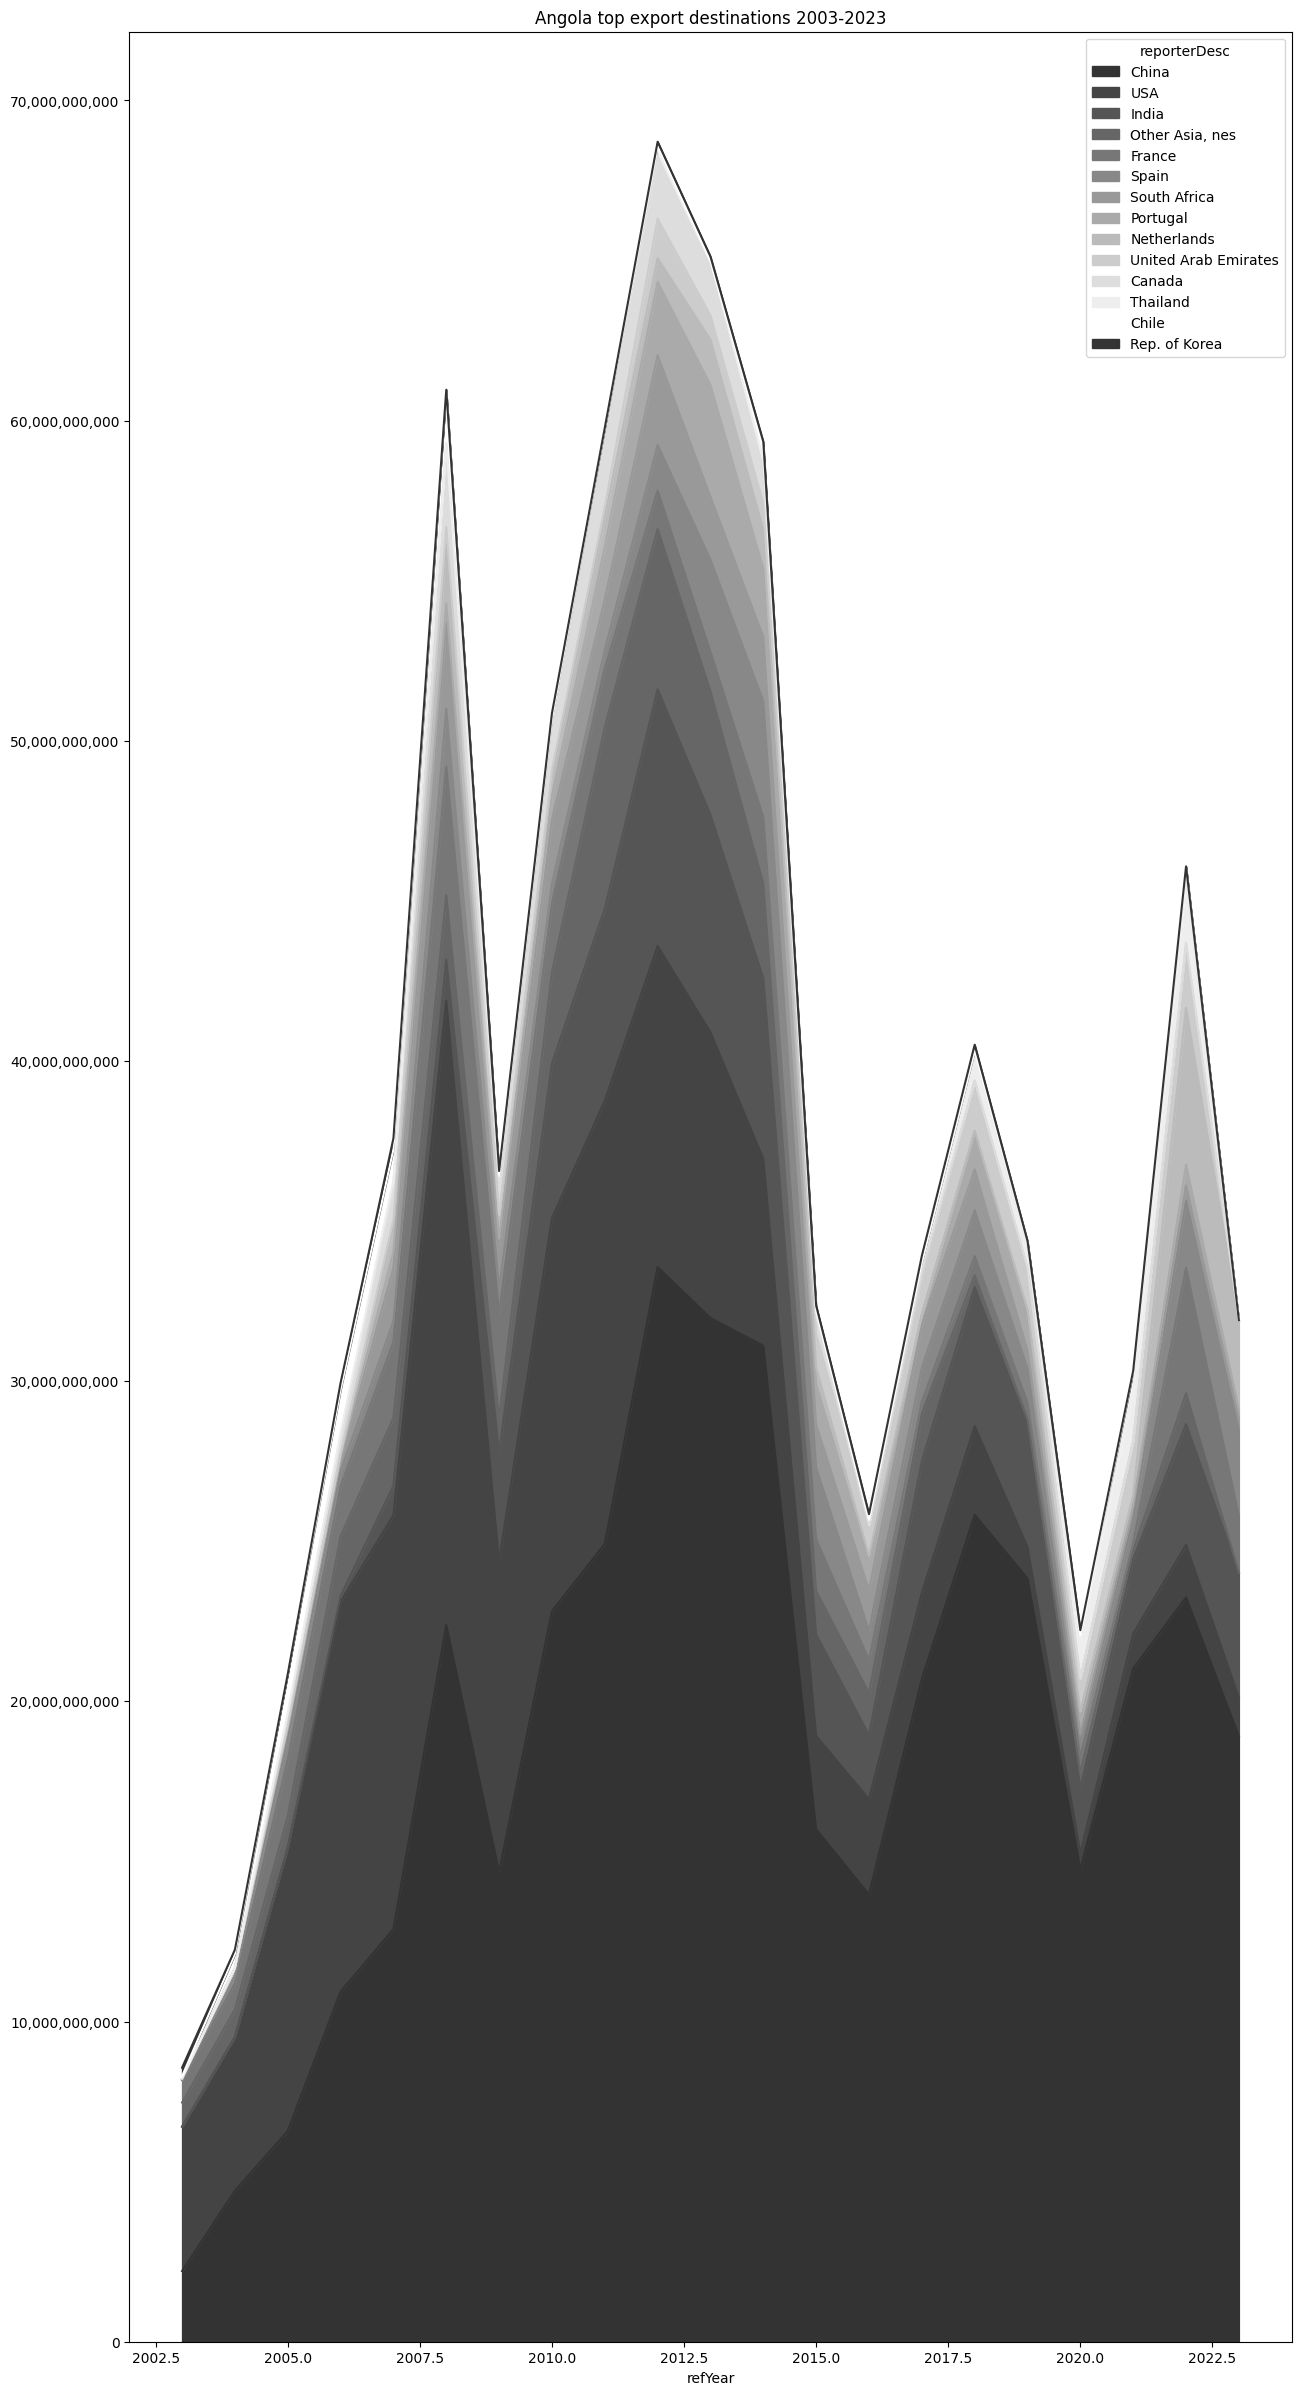

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

start_year=values_only.index.min()
end_year=values_only.index.max()
title=f"{country_of_interest_name} top export destinations {start_year}-{end_year}"
plotfile = f"reports/{country_of_interest_name}_export_partners_{start_year}-{end_year}.png"
print("Plot saved to ", plotfile)
# see https://matplotlib.org/stable/gallery/color/named_colors.html
# colors = ['red','lightsalmon','green','lightgreen','darkviolet','violet','blue','dodgerblue','orange','yellow','brown','black','grey','pink','cyan','magenta',]
# colors = ['crimson', 'darkorange', 'gold', 'limegreen', 'mediumseagreen', 'teal', 'deepskyblue', 'royalblue', 'indigo', 'mediumvioletred', 'hotpink', 'saddlebrown', 'grey', 'black', 'darkslategrey', 'darkkhaki']
colors = ['#333333', '#444444', '#555555', '#666666', '#777777', '#888888', '#999999', '#AAAAAA', '#BBBBBB', '#CCCCCC', '#DDDDDD', '#EEEEEE', '#FFFFFF']

fig2 = values_only.plot.area(figsize=(15,30),title=title, color=colors)
for i, line in enumerate(fig2.get_lines()):
    n = i % len(colors)
    print(i, line, colors[n])
    line.set_color(colors[n])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig2.yaxis.set_major_formatter(formatter)

plt.savefig(plotfile)
plt.show()

In [15]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_export_partners]

#### Export to Excel

Table with the top export destinations for the period of interest

In [16]:
top_partners_file = f'reports/{country_of_interest_name}_top_export_partners.xlsx'
top_partners_cols_file = f'reports/{country_of_interest_name}_top_export_partners_cols.xlsx'
export_top_partners_file = f'reports/{country_of_interest_name}_export_top_{show_only_top}_partners_{start_year}-{end_year}.xlsx'

exports.to_excel(top_partners_file)
pivoted.to_excel(top_partners_cols_file)
pivoted[show_only_columns].to_excel(export_top_partners_file)

print(f"Top partners file: {top_partners_file}")
print(f"Top partners cols file: {top_partners_cols_file}")
print(f"Export top partners file: {export_top_partners_file}")

Top partners file: reports/Angola_top_export_partners.xlsx
Top partners cols file: reports/Angola_top_export_partners_cols.xlsx
Export top partners file: reports/Angola_export_top_5_partners_2003-2023.xlsx


### Exports: products

### Main exported products

In [17]:
import pandas as pd

# show 500 lines of dataframes
pd.set_option('display.max_rows', 500)

show_only_top=5
# years_of_interest = comtrade.year_range(2020, 2021)

print(country_of_interest_name, years_of_interest)

Angola 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


Get the products exported by country of interest

In [18]:

# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = True  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = 0
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'



In [19]:
import comtradetools

clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World bank uses AG6
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True
                        )

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020,2021,2022,2023
INFO:root:Using cached results for period 2015,2016,2017,2018,2019,2020,2021,2022,2023


In [20]:
df.head()

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,A,20030101,2003,52,2003,120,CMR,Cameroon,M,...,"34,049.00",True,NaN,False,"11,589.00",NaN,"11,589.00",6,False,False
1,C,A,20030101,2003,52,2003,120,CMR,Cameroon,M,...,"67,041.00",False,NaN,False,"120,834.00",NaN,"120,834.00",0,False,False
2,C,A,20030101,2003,52,2003,120,CMR,Cameroon,M,...,"358,797.00",False,NaN,False,"109,590.00",NaN,"109,590.00",0,False,False
3,C,A,20030101,2003,52,2003,120,CMR,Cameroon,M,...,"3,128,350.00",False,NaN,False,"801,451.00",NaN,"801,451.00",0,False,False
4,C,A,20030101,2003,52,2003,120,CMR,Cameroon,M,...,"76,763.00",False,NaN,False,"23,194.00",NaN,"23,194.00",0,False,False


In [21]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
exports = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode'],'primaryValue','product',drop_duplicates=True)
exports = exports[exports['product_rank']<=show_only_top]
exports.info()

cols=['refYear','flowCode','cmdCode','product_sum','product_rank','product_upper_perc', 'product_upper_sum', 'cmdDesc']
formats =  comtradetools.make_format(cols)

top_export_products_codes = exports['cmdCode'].unique()

print(f"Top products exported by {country_of_interest_name} in {years_of_interest}:\n {top_export_products_codes}")
for cmdCode in top_export_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")
exports[cols].sort_values(['refYear','flowCode','product_rank']).style.format(formats)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 7 to 67038
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   typeCode                  105 non-null    object 
 1   freqCode                  105 non-null    object 
 2   refPeriodId               105 non-null    int64  
 3   refYear                   105 non-null    int64  
 4   refMonth                  105 non-null    int64  
 5   period                    105 non-null    object 
 6   reporterCode              105 non-null    int64  
 7   reporterISO               105 non-null    object 
 8   reporterDesc              105 non-null    object 
 9   flowCode                  105 non-null    object 
 10  flowDesc                  105 non-null    object 
 11  partnerCode               105 non-null    int64  
 12  partnerISO                105 non-null    object 
 13  partnerDesc               105 non-null    object 
 14  partner2

,refYear,flowCode,cmdCode,product_sum,product_rank,product_upper_perc,product_upper_sum,cmdDesc
7,2003,M,270900,"$8,804,250,597",1,94.455%,"$9,321,073,424","Oils; petroleum oils and oils obtained from bituminous minerals, crude"
26,2003,M,710231,"$277,225,900",2,2.974%,"$9,321,073,424","Diamonds; non-industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set"
79,2003,M,271019,"$140,536,071",3,1.508%,"$9,321,073,424","Oils; petroleum oils and oils obtained from bituminous minerals, not crude; preparations n.e.c., containing by weight 70% or more of petroleum oils or oils obtained from bituminous minerals, (excluding waste oils), other than light oils and preparations"
468,2003,M,271011,"$16,672,610",4,0.179%,"$9,321,073,424","Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations"
292,2003,M,730890,"$12,669,535",5,0.136%,"$9,321,073,424","Iron or steel; structures and parts thereof, n.e.s. in heading no. 7308"
1571,2004,M,270900,"$12,338,282,330",1,96.607%,"$12,771,576,748","Oils; petroleum oils and oils obtained from bituminous minerals, crude"
1835,2004,M,271019,"$168,682,119",2,1.321%,"$12,771,576,748","Oils; petroleum oils and oils obtained from bituminous minerals, not crude; preparations n.e.c., containing by weight 70% or more of petroleum oils or oils obtained from bituminous minerals, (excluding waste oils), other than light oils and preparations"
1506,2004,M,710231,"$136,904,563",3,1.072%,"$12,771,576,748","Diamonds; non-industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set"
1639,2004,M,271011,"$24,641,587",4,0.193%,"$12,771,576,748","Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations"
3018,2004,M,710239,"$13,829,634",5,0.108%,"$12,771,576,748","Diamonds; non-industrial, (other than unworked or simply sawn, cleaved or bruted), but not mounted or set"


#### Export to Excel

In [22]:
filename = f'reports/{country_of_interest_name}_exports_products_{clCode}-{cmdDetail}-{exports["refYear"].min()}-{exports["refYear"].max()}.xlsx'
print("Exporting to ",filename)
exports[cols].to_excel(filename,index=False)

Exporting to  reports/Angola_exports_products_HS-AG6-2003-2023.xlsx


### Export partners / products analysis

Which are the partners buying the top exports of country of interest?


In [23]:

# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = True  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'



In [24]:
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        partnerCode=partnerCode,
                        remove_world=True,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True
                        )

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020,2021,2022,2023
INFO:root:Using cached results for period 2015,2016,2017,2018,2019,2020,2021,2022,2023


In [25]:
import pandas as pd
import comtradetools
import warnings

# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
print(f"Top products exported by {country_of_interest_name} in {years_of_interest}:\n {top_export_products_codes}")
for cmdCode in top_export_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")

print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='cmd_partner'
# remove world
if 0 in df[f'{partner_column}Code'].unique():
    warnings.warn("Removing world from data")
    df = df[df[f'{partner_column}Code']!=0]

products_and_partners = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode',f'{partner_column}Code'],'primaryValue',prefix,drop_duplicates=True)

cols=['refYear','flowCode','cmdDesc','cmdCode',f'{partner_column}Desc',f'{prefix}_sum',f'{prefix}_rank',f'{prefix}_upper_sum',f'{prefix}_perc']
formats=comtradetools.make_format(cols)
products_and_partners=products_and_partners[(products_and_partners['cmdCode'].isin(top_export_products_codes)
                       & (products_and_partners[f'{prefix}_rank']<=show_only_top))]


Top products exported by Angola in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023:
 ['270900' '710231' '271019' '730890' '271011' '710239' '271112' '999999'
 '890520' '271119' '890190' '271111' '271012' '271500']
   270900: Oils; petroleum oils and oils obtained from bituminous minerals, crude
   710231: Diamonds; non-industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set
   271019: Petroleum oils and oils from bituminous minerals, not containing biodiesel, not crude, not waste oils; preparations n.e.c, containing by weight 70% or more of petroleum oils or oils from bituminous minerals; not light oils and preparations
   730890: Iron or steel; structures and parts thereof, n.e.c. in heading 7308
   271011: 271011
   710239: Diamonds; non-industrial, (other than unworked or simply sawn, cleaved or bruted), but not mounted or set
   271112: Petroleum gases and other gaseous hydrocarbons; liquefied, propane


### Partners for main export products

In [26]:
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                         ascending=[True,True,False,True])\
                                            .head(10).style.format(formats) #.hide(axis='index')

,refYear,flowCode,cmdDesc,cmdCode,reporterDesc,cmd_partner_sum,cmd_partner_rank,cmd_partner_upper_sum,cmd_partner_perc
1339,2003,M,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,USA,"$4,334,268,265",1,"$8,804,250,597",49.229%
78,2003,M,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,China,"$2,205,654,993",2,"$8,804,250,597",25.052%
465,2003,M,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,"Other Asia, nes","$754,792,400",3,"$8,804,250,597",8.573%
123,2003,M,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,France,"$693,177,977",4,"$8,804,250,597",7.873%
271,2003,M,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,Rep. of Korea,"$254,993,504",5,"$8,804,250,597",2.896%
26,2003,M,"Diamonds; non-industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710231,Belgium,"$256,473,845",1,"$277,225,900",92.514%
1358,2003,M,"Diamonds; non-industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710231,USA,"$20,640,087",2,"$277,225,900",7.445%
1318,2003,M,"Diamonds; non-industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710231,Thailand,"$64,571",3,"$277,225,900",0.023%
92,2003,M,"Diamonds; non-industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710231,China,"$47,397",4,"$277,225,900",0.017%
1343,2003,M,"Oils; petroleum oils and oils obtained from bituminous minerals, not crude; preparations n.e.c., containing by weight 70% or more of petroleum oils or oils obtained from bituminous minerals, (excluding waste oils), other than light oils and preparations",271019,USA,"$140,522,378",1,"$140,536,071",99.990%


In [27]:
filename = f'reports/{country_of_interest_name}_exports_partners_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}.xlsx'
products_and_partners[cols].to_excel(filename, index=False)
print("Exporting to ",filename)

Exporting to  reports/Angola_exports_partners_HS-AG6-2003-2023.xlsx


### Main partners and main products imported from country of interest

Detail of the main products by export partner.

Allows to analyse the mix of products of the main export partners from this country

In [28]:
top_export_partners

array(['China', 'France', 'Rep. of Korea', 'Other Asia, nes', 'USA',
       'Chile', 'South Africa', 'Canada', 'India', 'Portugal', 'Spain',
       'United Arab Emirates', 'Thailand', 'Netherlands'], dtype=object)

In [29]:
import comtradetools

print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='partner_cmd'
partners_and_products = comtradetools.total_rank_perc(df,['refYear','flowCode',f'{partner_column}Code','cmdCode'],'primaryValue',prefix,drop_duplicates=False)

cols=['refYear','flowCode',f'{partner_column}Desc','cmdDesc','cmdCode',f'{prefix}_sum',f'{prefix}_rank',f'{prefix}_upper_sum',f'{prefix}_perc']
formats = comtradetools.make_format(cols)
partners_and_products=partners_and_products[(partners_and_products[f'{partner_column}Desc'].isin(top_export_partners)
                       & (partners_and_products[f'{prefix}_rank']<=show_only_top))]

print("First rows")
partners_and_products[partners_and_products[f'{prefix}_rank']<show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).head(10).style.format(formats).hide(axis='index')

Top export partners (14): ['China' 'France' 'Rep. of Korea' 'Other Asia, nes' 'USA' 'Chile'
 'South Africa' 'Canada' 'India' 'Portugal' 'Spain' 'United Arab Emirates'
 'Thailand' 'Netherlands']
First rows


refYear,flowCode,reporterDesc,cmdDesc,cmdCode,partner_cmd_sum,partner_cmd_rank,partner_cmd_upper_sum,partner_cmd_perc
2003,M,USA,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,"$4,334,268,265",1,"$4,508,909,969",96.127%
2003,M,USA,"Oils; petroleum oils and oils obtained from bituminous minerals, not crude; preparations n.e.c., containing by weight 70% or more of petroleum oils or oils obtained from bituminous minerals, (excluding waste oils), other than light oils and preparations",271019,"$140,522,378",2,"$4,508,909,969",3.117%
2003,M,USA,"Diamonds; non-industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710231,"$20,640,087",3,"$4,508,909,969",0.458%
2003,M,USA,"Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations",271011,"$7,908,922",4,"$4,508,909,969",0.175%
2003,M,China,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,"$2,205,654,993",1,"$2,205,934,880",99.987%
2003,M,China,Granite; crude or roughly trimmed,251611,"$232,059",2,"$2,205,934,880",0.011%
2003,M,China,"Diamonds; non-industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710231,"$47,397",3,"$2,205,934,880",0.002%
2003,M,China,Plastics; other articles n.e.s. in chapter 39,392690,$257,4,"$2,205,934,880",0.000%
2003,M,"Other Asia, nes","Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,"$754,792,400",1,"$754,817,300",99.997%
2003,M,"Other Asia, nes",Granite; crude or roughly trimmed,251611,"$12,800",2,"$754,817,300",0.002%


Last rows

In [30]:
partners_and_products[partners_and_products[f'{prefix}_rank']<show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).tail(10).style.format(formats).hide(axis='index')

refYear,flowCode,reporterDesc,cmdDesc,cmdCode,partner_cmd_sum,partner_cmd_rank,partner_cmd_upper_sum,partner_cmd_perc
2023,M,Portugal,"Fruit, edible; bananas, other than plantains, fresh or dried",080390,"$9,684,122",2,"$293,020,792",3.305%
2023,M,Portugal,"Crustaceans; frozen, shrimps and prawns, excluding cold-water varieties, in shell or not, smoked, cooked or not before or during smoking; in shell, cooked by steaming or by boiling in water",030617,"$6,877,505",3,"$293,020,792",2.347%
2023,M,Portugal,"Granite; merely cut, by sawing or otherwise, into blocks or slabs of a rectangular (including square) shape",251612,"$3,875,262",4,"$293,020,792",1.323%
2023,M,Canada,"Wood, tropical, n.e.c. in item no. 4407.2, sawn or chipped lengthwise, sliced or peeled, whether or not planed, sanded or finger-jointed, of a thickness exceeding 6mm",440729,"$78,788",1,"$106,015",74.318%
2023,M,Canada,"Diamonds; non-industrial, (other than unworked or simply sawn, cleaved or bruted), but not mounted or set",710239,"$10,499",2,"$106,015",9.904%
2023,M,Canada,Vehicle parts; suspension systems and parts thereof (including shock-absorbers),870880,"$6,608",3,"$106,015",6.233%
2023,M,Canada,"Fish; smoked, whether or not cooked before or during smoking, n.e.c. in item no. 0305.4, includes fillets, but excludes edible fish offal",030549,"$3,219",4,"$106,015",3.036%
2023,M,Chile,Vehicle parts and accessories; n.e.c. in heading no. 8708,870899,"$1,604",1,"$2,772",57.873%
2023,M,Chile,Vehicle parts; silencers (mufflers) and exhaust pipes; parts thereof,870892,$958,2,"$2,772",34.541%
2023,M,Chile,"Plastics; plates, sheets, film, foil, tape, strip, other flat shapes thereof, self-adhesive, other than in rolls of a width not exceeding 20cm",391990,$210,3,"$2,772",7.586%


## Get the alternative suppliers for country_of_interest partners




For each year, partner, exported commodity, fetches all the imports of
the commodity by partner from other countries, and computes the ranking
of country of interest among the suppliers of partner for that commodity,
e.g.

Country of interest：Angola, in 2021, China, exported commodity code 270900 "Oils; petroleum oils and oils obtained 
from bituminous minerals, crude" ; fetch all suppliers of 270900 of China and compute
the ranking of Angola.


First step is to get the combos of partner and commodity

In [31]:
combos_of_interest = partners_and_products[(partners_and_products['cmdCode'].isin(top_export_products_codes)
                & (partners_and_products[f'{partner_column}Code'].isin(top_export_partners_codes)))][[f'{partner_column}Code','cmdCode']].drop_duplicates()
combos_of_interest = [tuple(x) for x in combos_of_interest.values]
len(combos_of_interest)

73

In [32]:
cmdCode_list = [cmdCode for (countryCode,cmdCode) in combos_of_interest]
cmdCode_list = list(set(cmdCode_list))
countryCode_list = [countryCode for (countryCode,cmdCode) in combos_of_interest]
countryCode_list = list(set(countryCode_list))
cmdCodeCSV = ','.join(cmdCode_list)
countryCodeCSV = ','.join(map(str,countryCode_list))

In [33]:
print("Years of interest: ", years_of_interest)
print("countryCodeCSV: ", countryCodeCSV)
print("cmdCodeCSV: ", cmdCodeCSV)

df = comtradetools.getFinalData(APIKEY,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode='M',
                                reporterCode=countryCodeCSV,
                                partnerCode=None,
                                remove_world=True,
                                partner2Code=0,
                                period=years_of_interest,
                                period_size=6,
                                clCode=clCode,
                                cmdCode=cmdCodeCSV,  # Top level product types
                                motCode=0,  # all means of transport
                                customsCode='C00',
                                includeDesc=True,
                                cache=True,

                       )

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008


Years of interest:  2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
countryCodeCSV:  764,710,490,842,620,528,124,784,724,152,410,251,156,699
cmdCodeCSV:  271112,999999,271111,710239,271119,271019,271500,271012,271011,710231,890190,730890,270900


INFO:root:Calling getFinalData for period 2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020
INFO:root:Calling getFinalData for period 2021,2022,2023


Alternative, concatenating

In [39]:
import pandas as pd

try_alternative = False

if try_alternative:
    df2: pd.DataFrame = None
    for countryCode,cmdCode in combos_of_interest:
        print(countryCode,cmdCode)
        tmp = comtradetools.getFinalData(APIKEY,
                                        reporterCode=countryCode,
                                        typeCode='C',  # commodities
                                        freqCode='A',  # annual
                                        flowCode='M',
                                        partnerCode=None,
                                        remove_world=True,
                                        partner2Code=0,
                                        period=years_of_interest,
                                        period_size=6,
                                        clCode='HS',
                                        cmdCode=cmdCode,  # Top level product types
                                        customsCode='C00',
                                        motCode=0,  # all means of transport
                                        )
        if df2 is None:
            df2 = tmp
        else:
            df2 = pd.concat([df2,tmp],axis=0)


Partners buying top products of country of interest.

In [40]:
df.reporterDesc.unique()

array(['Canada', 'China', 'Chile', 'France', 'Rep. of Korea', 'Portugal',
       'Netherlands', 'Other Asia, nes', 'South Africa', 'India', 'Spain',
       'Thailand', 'United Arab Emirates', 'USA'], dtype=object)

For each partner show the top supliers of the products bought from country of interest. 

If country of interest is not in the top five show position anyway if it is a supplier in the given year 

In [41]:
import pandas as pd
import comtradetools

#  set max rows to 500
pd.set_option('display.max_rows', 1500)


other_suppliers = comtradetools.total_rank_perc(
                                        df,
                                        groupby=['refYear','flowCode','reporterCode','cmdCode','partnerCode'],
                                        col='primaryValue',
                                        prefix='cmd_partner',
                                        )

other_suppliers = other_suppliers[other_suppliers[['reporterCode','cmdCode']].apply(tuple,axis=1).isin(combos_of_interest)]
cols=['reporterDesc','cmdCode','cmdDesc','refYear','partnerDesc','cmd_partner_rank','cmd_partner_upper_sum','cmd_partner_perc','primaryValue']
formats =  comtradetools.make_format(cols)

other_suppliers[(other_suppliers['partnerCode'] == country_of_interest)
                | (other_suppliers['cmd_partner_rank']<=show_only_top)
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).head(20).style.format(formats).hide(axis="index")

reporterDesc,cmdCode,cmdDesc,refYear,partnerDesc,cmd_partner_rank,cmd_partner_upper_sum,cmd_partner_perc,primaryValue
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2003,Norway,1,"$9,877,194,452",28.065%,"$2,772,038,190"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2003,United Kingdom,2,"$9,877,194,452",19.238%,"$1,900,125,321"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2003,Algeria,3,"$9,877,194,452",17.011%,"$1,680,173,461"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2003,Iraq,4,"$9,877,194,452",8.154%,"$805,429,136"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2003,Saudi Arabia,5,"$9,877,194,452",5.820%,"$574,808,092"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2004,Norway,1,"$12,361,243,820",28.918%,"$3,574,664,455"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2004,Algeria,2,"$12,361,243,820",19.244%,"$2,378,849,061"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2004,United Kingdom,3,"$12,361,243,820",17.273%,"$2,135,192,802"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2004,Saudi Arabia,4,"$12,361,243,820",6.950%,"$859,137,600"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2004,Iraq,5,"$12,361,243,820",6.858%,"$847,703,131"


### Ranking of country of interest in the supliers of main export products

Allows assessment of the importance of country of interest for the partners
that are buying its main exports.

In [42]:
other_suppliers[
    (other_suppliers['partnerCode'
                     ] == country_of_interest)][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']
                          ).head(50).style.format(formats).hide(axis='index')

reporterDesc,cmdCode,cmdDesc,refYear,partnerDesc,cmd_partner_rank,cmd_partner_upper_sum,cmd_partner_perc,primaryValue
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2005,Angola,12,"$18,090,860,235",1.517%,"$274,446,268"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2006,Angola,11,"$20,609,292,977",2.588%,"$533,428,794"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2007,Angola,6,"$22,538,781,351",4.959%,"$1,117,722,656"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2008,Angola,4,"$31,982,421,236",8.152%,"$2,607,160,823"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2009,Angola,7,"$18,503,685,618",6.523%,"$1,206,904,802"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2010,Angola,8,"$23,082,122,622",6.820%,"$1,574,222,990"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2011,Angola,6,"$28,824,422,617",8.567%,"$2,469,326,199"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2012,Angola,8,"$29,788,759,667",6.480%,"$1,930,372,689"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2013,Angola,7,"$26,237,946,570",5.744%,"$1,507,165,700"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2014,Angola,6,"$21,513,345,469",4.954%,"$1,065,876,478"


In [43]:
filename = f'reports/{country_of_interest_name}_export_partners_alternative.xlsx'
print("Exporting to ",filename)
other_suppliers.to_excel(filename)

Exporting to  reports/Angola_export_partners_alternative.xlsx


## Imports

In [45]:
print(country_of_interest_name, years_of_interest)

Angola 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


### Main import partners

Collect imports to country of interest.

Use either reported imports by country of interest, 
or reported exports to country of interest by
all other countries (symmetric reporting). 

Set variable `symmetric_reporting` to choose.

In [46]:
# If symmetric_reporting is "True" we get the imports from
#    the reported exports of all the countries
# i.e. instead of asking Country of Interest for import data we ask the world
#    for export data towards Country of Interest

symmetric_reporting = False  # set to false to use reported imports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'



In [47]:
clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World bank uses AG6, but some codes AG4
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,  # imports
                        partnerCode=partnerCode, # every body
                        remove_world=True,
                        partner2Code=0, # ignore parter2
                        period=years_of_interest,
                        clCode="HS",
                        cmdCode="TOTAL",
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True
                        )

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020,2021,2022,2023
INFO:root:Using cached results for period 2015,2016,2017,2018,2019,2020,2021,2022,2023


Compute percentage o trade and rank of partners for each year.

Use `show_only_top` to show only the top partners (e.g. 5).

In [48]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
partner_column = 'partner'
reporter_column = 'reporter'

# aggregate by year, flow, reporter
imports = comtradetools.total_rank_perc(df,groupby=['refYear','flowCode',f'{partner_column}Desc'],
                                    col='primaryValue',
                                    prefix='partner',
                                    drop_duplicates=True)

cols=['refYear','flowCode',f'{partner_column}Desc','cmdCode','partner_upper_sum','partner_sum','partner_rank','partner_perc','partner_upper_perc']

formats =  comtradetools.make_format(cols)

top_import_partners = imports[imports['partner_rank']<=show_only_top][f'{partner_column}Desc'].unique()
top_import_partners_codes = imports[imports['partner_rank']<=show_only_top][f'{partner_column}Code'].unique()

print(f"Top {show_only_top} import partners of {country_of_interest_name} in {years_of_interest}: \n{top_import_partners}")
imports[imports['partner_rank']<=show_only_top][cols].sort_values(['refYear','flowCode','partner_rank',f'{partner_column}Desc','cmdCode']).style.format(formats)

Top 5 import partners of Angola in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023: 
['China' "Dem. People's Rep. of Korea" 'Portugal' 'USA' 'Areas, nes'
 'Brazil' 'South Africa' 'Netherlands' 'Rep. of Korea' 'Singapore'
 'Belgium' 'Togo' 'France' 'India']


,refYear,flowCode,partnerDesc,cmdCode,partner_upper_sum,partner_sum,partner_rank,partner_perc,partner_upper_perc
165,2007,M,Portugal,TOTAL,"$11,094,843,419","$1,641,640,086",1,14.796%,14.796%
108,2007,M,Dem. People's Rep. of Korea,TOTAL,"$11,094,843,419","$1,051,122,766",2,9.474%,9.474%
219,2007,M,USA,TOTAL,"$11,094,843,419","$995,114,611",3,8.969%,8.969%
228,2007,M,"Areas, nes",TOTAL,"$11,094,843,419","$958,097,638",4,8.636%,8.636%
43,2007,M,China,TOTAL,"$11,094,843,419","$864,709,131",5,7.794%,7.794%
373,2009,M,Portugal,TOTAL,"$23,918,854,355","$3,704,037,715",1,15.486%,15.486%
268,2009,M,China,TOTAL,"$23,918,854,355","$2,094,782,750",2,8.758%,8.758%
414,2009,M,USA,TOTAL,"$23,918,854,355","$1,947,700,684",3,8.143%,8.143%
253,2009,M,Brazil,TOTAL,"$23,918,854,355","$1,587,724,279",4,6.638%,6.638%
393,2009,M,South Africa,TOTAL,"$23,918,854,355","$1,465,902,027",5,6.129%,6.129%


Pivot the countries to columns, keeping the total value and percentage in separate columns.

----

Passamos os países para colunas, mantendo a percentagem e o valor em separado.

In [49]:
pivoted = df.pivot_table(index=['refYear','flowDesc'], columns=f'{partner_column}Desc', values=['primaryValue','partner_perc'])
pivoted.swaplevel(axis=1).fillna('',inplace=True)
pivoted.sort_index(axis=1, level=0, inplace=True)
pivoted.fillna(0)

partner_perc                                                \
partnerDesc       Afghanistan Albania Algeria American Samoa Andorra Angola   
refYear flowDesc                                                              
2007    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2009    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2010    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2011    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2012    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2013    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2014    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2015    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2016    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2017    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2018    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2019    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2020    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2021    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2022    Import           0.00    0.00    0.00           0.00    0.00   0.00   

                                                                     ...  \
partnerDesc      Anguilla Antarctica Antigua and Barbuda Areas, nes  ...   
refYear flowDesc                                                     ...   
2007    Import       0.00       0.00                0.00       0.09  ...   
2009    Import       0.00       0.00                0.00       0.00  ...   
2010    Import       0.00       0.00                0.00       0.00  ...   
2011    Import       0.00       0.00                0.00       0.00  ...   
2012    Import       0.00       0.00                0.00       0.00  ...   
2013    Import       0.00       0.00                0.00       0.00  ...   
2014    Import       0.00       0.00                0.00       0.00  ...   
2015    Import       0.00       0.00                0.00       0.00  ...   
2016    Import       0.00       0.00                0.00       0.00  ...   
2017    Import       0.00       0.00                0.00       0.00  ...   
2018    Import       0.00       0.00                0.00       0.00  ...   
2019    Import       0.00       0.00                0.00       0.00  ...   
2020    Import       0.00       0.00                0.00       0.00  ...   
2021    Import       0.00       0.00                0.00       0.00  ...   
2022    Import       0.00       0.00                0.00       0.00  ...   

                  primaryValue                                       \
partnerDesc            Uruguay Uzbekistan      Vanuatu    Venezuela   
refYear flowDesc                                                      
2007    Import   19,243,877.00  15,260.00    15,260.00   162,445.00   
2009    Import   12,023,947.00   1,432.00   225,760.00   342,849.00   
2010    Import   11,722,898.00       0.00         0.00    61,251.00   
2011    Import   13,351,093.00       0.00         0.00   144,495.00   
2012    Import   38,621,863.00  62,719.00         0.00   137,930.00   
2013    Import   25,980,751.00       0.00         0.00    71,647.00   
2014    Import   20,165,145.00       0.00         0.00   130,835.00   
2015    Import    7,498,894.53       0.00         0.00     5,050.04   
2016    Import    3,521,792.85       0.00 1,449,913.29   388,461.42   
2017    Import    4,716,321.41       0.00         0.00 5,966,464.75   
2018    Import   17,434,600.81      33.26         0.00   163,309.61   
2019    Import    6,478,609.20   1,843.88     8,526.07 3,014,394.65   
2020    Import   21,915,058.23     218.56         0.00 2,663,118.41   
2021    Import    1,399,442.47 226,071.61    57,168.89    21,224.14   
2022    Import    

Limit table to top_export_partners

Note that the number of top partners considered was set before with `show_only_top` (e.g. 5).

But each year the top partners may vary, so that the total number of partners for the period will be
more than `show_only_top`.

In [50]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_import_partners]
pivoted[show_only_columns]

partner_perc                       \
partnerDesc        Areas, nes Belgium Brazil China   
refYear flowDesc                                     
2007    Import           0.09    0.04   0.06  0.08   
2009    Import           0.00    0.04   0.07  0.09   
2010    Import           0.00    0.04   0.05  0.10   
2011    Import           0.00    0.03   0.05  0.09   
2012    Import           0.00    0.04   0.05  0.12   
2013    Import           0.00    0.03   0.04  0.10   
2014    Import           0.00    0.04   0.05  0.12   
2015    Import           0.00    0.04   0.04  0.15   
2016    Import            NaN    0.04   0.05  0.12   
2017    Import           0.00    0.04   0.06  0.14   
2018    Import            NaN    0.07   0.05  0.15   
2019    Import            NaN    0.07   0.04  0.15   
2020    Import            NaN    0.04   0.06  0.15   
2021    Import            NaN    0.03   0.05  0.15   
2022    Import           0.00    0.05   0.04  0.16   

                                                                       \
partnerDesc      Dem. People's Rep. of Korea France India Netherlands   
refYear flowDesc                                                        
2007    Import                          0.09   0.04  0.01        0.01   
2009    Import                          0.00   0.03  0.05        0.05   
2010    Import                          0.00   0.05  0.03        0.11   
2011    Import                          0.00   0.04  0.02        0.09   
2012    Import                          0.00   0.04  0.03        0.02   
2013    Import                          0.00   0.03  0.02        0.03   
2014    Import                          0.00   0.04  0.02        0.02   
2015    Import                          0.00   0.03  0.02        0.02   
2016    Import                          0.00   0.03  0.02        0.02   
2017    Import                          0.00   0.03  0.03        0.02   
2018    Import                          0.00   0.03  0.03        0.01   
2019    Import                          0.00   0.13  0.03        0.01   
2020    Import                          0.00   0.03  0.05        0.01   
2021    Import                          0.00   0.04  0.07        0.04   
2022    Import                          0.00   0.02  0.06        0.07   

                                         ...                primaryValue  \
partnerDesc      Portugal Rep. of Korea  ... Dem. People's Rep. of Korea   
refYear flowDesc                         ...                               
2007    Import       0.15          0.01  ...            1,051,122,766.00   
2009    Import       0.15          0.02  ...                1,780,955.00   
2010    Import       0.14          0.01  ...               16,776,134.00   
2011    Import       0.17          0.11  ...                1,297,461.00   
2012    Import       0.19          0.02  ...                4,647,583.00   
2013    Import       0.16          0.16  ...                1,865,344.00   
2014    Import       0.17          0.02  ...                5,446,928.00   
2015    Import       0.13          0.03  ...               44,078,505.54   
2016    Import       0.13          0.03  ...                2,623,377.10   
2017    Import       0.17          0.02  ...               22,911,479.23   
2018    Import       0.14          0.02  ...                3,128,419.80   
2019    Import       0.13          0.05  ...               14,150,699.43   
2020    Import       0.14          0.03  ...                2,428,705.36   
2021    Import       0.12          0.02  ...                1,648,905.56   
2022    Import       0.11          0.09  ...                3,530,526.04   

                                                                     \
partnerDesc                France            India      Netherlands   
refYear flowDesc                                                      
2007    Import     428,509,154.00   146,755,323.00   156,598,435.00   
2009    Import     686,740,225.00 1,171,807,310.00 1,260,263,169.00   
2010 

Make a table with the total value of import from top partners in the period of interest

In [51]:
print("Top partners for import: ",top_import_partners)
print("Period of interest:",years_of_interest)

Top partners for import:  ['China' "Dem. People's Rep. of Korea" 'Portugal' 'USA' 'Areas, nes'
 'Brazil' 'South Africa' 'Netherlands' 'Rep. of Korea' 'Singapore'
 'Belgium' 'Togo' 'France' 'India']
Period of interest: 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


In [52]:
import pandas as pd

# lets get just the value of imports from the top export partners
values_only = pivoted.loc[:,"primaryValue"]
values_only.reset_index(level=1, drop=True, inplace=True)
show_only_columns = [country for country in values_only.columns.tolist() if country in top_import_partners]
values_only=values_only[show_only_columns]
# sort columns by mean value
mean_values = values_only.mean().sort_values(ascending=False)
values_only = values_only[mean_values.index]
values_only

partnerDesc,Portugal,China,USA,Brazil,Rep. of Korea,South Africa,Singapore,Belgium,France,Netherlands,India,Togo,"Areas, nes",Dem. People's Rep. of Korea
refYear,,,,,,,,,,,,,,
2007,"1,641,640,086.00","864,709,131.00","995,114,611.00","670,797,879.00","131,912,828.00","557,340,948.00","66,634,727.00","445,866,237.00","428,509,154.00","156,598,435.00","146,755,323.00","20,254,719.00","958,097,638.00","1,051,122,766.00"
2009,"3,704,037,715.00","2,094,782,750.00","1,947,700,684.00","1,587,724,279.00","444,453,753.00","1,465,902,027.00","192,191,793.00","900,148,143.00","686,740,225.00","1,260,263,169.00","1,171,807,310.00","49,185,726.00","28,335,855.00","1,780,955.00"
2010,"2,607,038,140.00","1,829,198,708.00","1,679,331,344.00","963,915,131.00","201,097,941.00","843,147,039.00","136,351,315.00","812,816,037.00","887,017,586.00","2,050,638,945.00","533,470,722.00","36,634,042.00","12,221,703.00","16,776,134.00"
2011,"3,455,494,969.00","1,837,128,963.00","1,747,664,018.00","939,992,479.00","2,349,725,667.00","987,867,818.00","354,506,804.00","633,415,232.00","855,179,886.00","1,816,622,261.00","340,990,172.00","35,376,682.00","609,705.00","1,297,461.00"
2012,"5,378,237,289.00","3,457,048,494.00","2,416,207,234.00","1,504,223,663.00","543,132,607.00","1,535,782,348.00","2,212,481,628.00","1,063,456,547.00","1,090,928,236.00","609,718,935.00","721,158,376.00","446,205.00","352,515.00","4,647,583.00"
2013,"4,339,196,450.00","2,807,559,763.00","1,678,238,536.00","1,185,093,950.00","4,239,548,971.00","1,198,043,342.00","1,402,073,500.00","831,660,513.00","712,450,729.00","721,968,940.00","464,625,959.00","5,591,165.00","147,193.00","1,865,344.00"
2014,"4,781,920,802.00","3,428,512,382.00","2,293,681,442.00","1,563,690,066.00","571,951,003.00","1,296,033,624.00","2,515,380,861.00","1,011,226,934.00","1,027,323,408.00","475,615,616.00","635,953,408.00","19,061,672.00","492,580.00","5,446,928.00"
2015,"2,783,117,807.23","3,311,091,334.27","1,720,304,160.25","874,844,000.65","721,535,063.60","1,007,873,691.42","2,092,488,997.18","836,612,948.45","707,316,898.24","338,419,286.55","430,719,483.58","232,903,417.81","255,128.21","44,078,505.54"
2016,"1,902,467,438.06","1,674,919,663.10","1,698,553,246.44","668,479,595.26","425,751,449.14","678,586,059.61","523,593,020.12","608,878,658.34","456,830,241.30","223,673,242.28","326,782,250.15","77,583,740.59",NaN,"2,623,377.10"


0 Line2D(_child0) #333333
1 Line2D(_child2) #444444
2 Line2D(_child4) #555555
3 Line2D(_child6) #666666
4 Line2D(_child8) #777777
5 Line2D(_child10) #888888
6 Line2D(_child12) #999999
7 Line2D(_child14) #AAAAAA
8 Line2D(_child16) #BBBBBB
9 Line2D(_child18) #CCCCCC
10 Line2D(_child20) #DDDDDD
11 Line2D(_child22) #EEEEEE
12 Line2D(_child24) #333333
13 Line2D(_child26) #444444


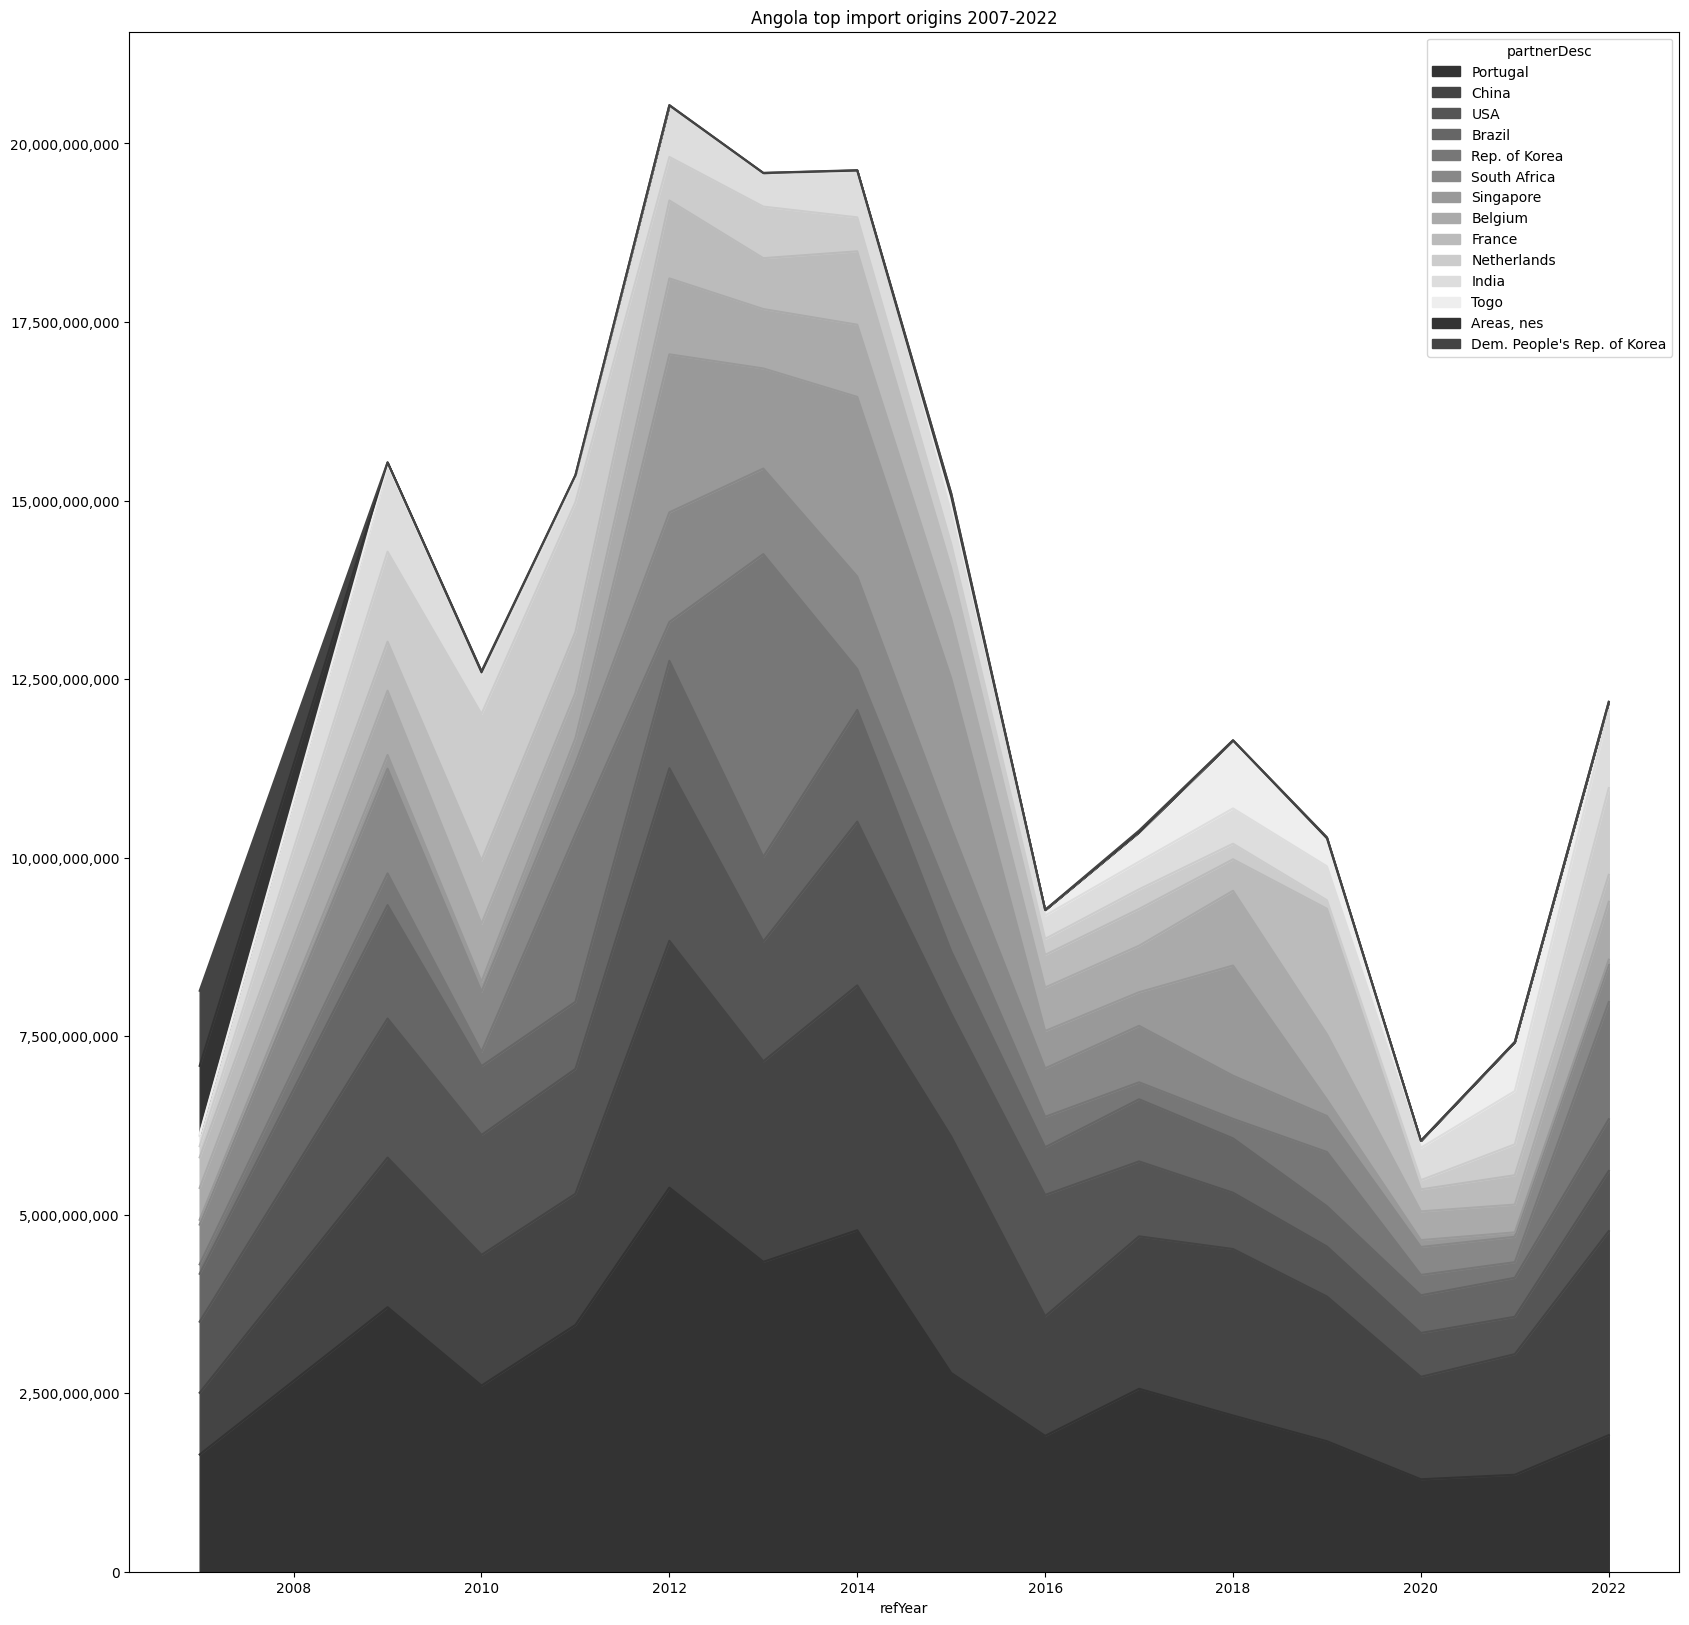

In [58]:
import matplotlib.pyplot as plt


# colors = ['red','lightsalmon','green','lightgreen','darkviolet','violet','blue','dodgerblue','orange','yellow','brown','black','grey','pink','cyan','magenta',]
# colors = ['crimson', 'darkorange', 'gold', 'limegreen', 'mediumseagreen', 'teal', 'deepskyblue', 'royalblue', 'indigo', 'mediumvioletred', 'hotpink', 'saddlebrown', 'grey', 'black', 'darkslategrey', 'darkkhaki']

colors = [ '#333333','#444444', '#555555', '#666666', '#777777', '#888888', '#999999', '#AAAAAA', '#BBBBBB', '#CCCCCC', '#DDDDDD', '#EEEEEE']
fig2 = values_only.plot.area(figsize=(20,20),title=title, color=colors)

for i, line in enumerate(fig2.get_lines()):
    n = i % len(colors)
    print(i, line, colors[n])
    line.set_color(colors[n])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig2.yaxis.set_major_formatter(formatter)

plt.savefig(plotfile)
plt.show()

In [59]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_import_partners]

#### Export to Excel

Table with the top import originins for the period of interest

In [60]:
top_partners_file = f'reports/{country_of_interest_name}_top_import_partners.xlsx'
top_partners_cols_file = f'reports/{country_of_interest_name}_top_import_partners_cols.xlsx'
import_top_partners_file = f'reports/{country_of_interest_name}_import_top_{show_only_top}_partners_{start_year}-{end_year}.xlsx'

imports.to_excel(top_partners_file)
pivoted.to_excel(top_partners_cols_file)
pivoted[show_only_columns].reset_index().to_excel(import_top_partners_file)

print(f"Top import partners file: {top_partners_file}")
print(f"Top import partners cols file: {top_partners_cols_file}")
print(f"Import top partners file: {import_top_partners_file}")

Top import partners file: reports/Angola_top_import_partners.xlsx
Top import partners cols file: reports/Angola_top_import_partners_cols.xlsx
Import top partners file: reports/Angola_import_top_5_partners_2007-2022.xlsx


### Imports: products

In [61]:
import pandas as pd

# show 500 lines of dataframes
pd.set_option('display.max_rows', 500)

show_only_top=5
# years_of_interest = comtrade.year_range(2020, 2021)

print(country_of_interest_name, years_of_interest)


Angola 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


Get the products imported by country of interest

In [62]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = False  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = 0
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'

In [63]:
import comtradetools

clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World bank uses AG6
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True
                        )
df.info()

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020,2021,2022,2023
INFO:root:Using cached results for period 2015,2016,2017,2018,2019,2020,2021,2022,2023


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67759 entries, 0 to 67758
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   typeCode                  67759 non-null  object 
 1   freqCode                  67759 non-null  object 
 2   refPeriodId               67759 non-null  int64  
 3   refYear                   67759 non-null  int64  
 4   refMonth                  67759 non-null  int64  
 5   period                    67759 non-null  object 
 6   reporterCode              67759 non-null  int64  
 7   reporterISO               67759 non-null  object 
 8   reporterDesc              67759 non-null  object 
 9   flowCode                  67759 non-null  object 
 10  flowDesc                  67759 non-null  object 
 11  partnerCode               67759 non-null  int64  
 12  partnerISO                67759 non-null  object 
 13  partnerDesc               67759 non-null  object 
 14  partne

In [64]:
print("Years available in the data:", list(df.refYear.unique()))

Years available in the data: [2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [65]:
df.head()

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,A,20070101,2007,52,2007,24,AGO,Angola,M,...,"70,634.00",False,NaN,False,"258,036.00",NaN,"258,036.00",0,True,False
1,C,A,20070101,2007,52,2007,24,AGO,Angola,M,...,73.00,False,NaN,False,167.00,NaN,167.00,0,True,False
2,C,A,20070101,2007,52,2007,24,AGO,Angola,M,...,993.00,False,NaN,False,"3,908.00",NaN,"3,908.00",0,True,False
3,C,A,20070101,2007,52,2007,24,AGO,Angola,M,...,5.00,False,NaN,False,59.00,NaN,59.00,0,True,False
4,C,A,20070101,2007,52,2007,24,AGO,Angola,M,...,"1,649.00",False,NaN,False,"14,373.00",NaN,"14,373.00",0,True,False


In [66]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
imports = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode'],'primaryValue','product',drop_duplicates=True)
imports = imports[imports['product_rank']<=show_only_top]
imports.info()

cols=['refYear','flowCode','classificationCode','cmdCode','aggrLevel','isLeaf','product_sum','product_rank','product_upper_perc', 'product_upper_sum', 'cmdDesc']
formats =  comtradetools.make_format(cols)

top_import_products_codes = imports['cmdCode'].unique()

print(f"Top products imported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")
for cmdCode in top_import_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")
imports[cols].sort_values(['refYear','flowCode','product_rank']).style.format(formats)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 2807 to 64906
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   typeCode                  75 non-null     object 
 1   freqCode                  75 non-null     object 
 2   refPeriodId               75 non-null     int64  
 3   refYear                   75 non-null     int64  
 4   refMonth                  75 non-null     int64  
 5   period                    75 non-null     object 
 6   reporterCode              75 non-null     int64  
 7   reporterISO               75 non-null     object 
 8   reporterDesc              75 non-null     object 
 9   flowCode                  75 non-null     object 
 10  flowDesc                  75 non-null     object 
 11  partnerCode               75 non-null     int64  
 12  partnerISO                75 non-null     object 
 13  partnerDesc               75 non-null     object 
 14  partne

,refYear,flowCode,classificationCode,cmdCode,aggrLevel,isLeaf,product_sum,product_rank,product_upper_perc,product_upper_sum,cmdDesc
3985,2007,M,H2,843149,6,True,"$1,081,590,357",1,9.749%,"$11,094,843,423","Machinery; parts of machines handling earth, minerals or ores and n.e.s. in heading no. 8431"
3984,2007,M,H2,843143,6,True,"$470,198,098",2,4.238%,"$11,094,843,423",Boring or sinking machinery; parts of the machinery of item no. 8430.41 or 8430.41
4255,2007,M,H2,870421,6,True,"$243,063,746",3,2.191%,"$11,094,843,423","Vehicles; compression-ignition internal combustion piston engine (diesel or semi-diesel), for transport of goods, (of a gvw not exceeding 5 tonnes), nes in item no 8704.1"
4242,2007,M,H2,870323,6,True,"$162,981,017",4,1.469%,"$11,094,843,423","Vehicles; spark-ignition internal combustion reciprocating piston engine, cylinder capacity exceeding 1500cc but not exceeding 3000cc"
2807,2007,M,H2,110100,6,True,"$123,657,799",5,1.115%,"$11,094,843,423",Wheat or meslin flour
5183,2009,M,H3,271019,6,True,"$2,238,654,044",1,9.359%,"$23,918,854,386","Oils; petroleum oils and oils obtained from bituminous minerals, not crude; preparations n.e.c., containing by weight 70% or more of petroleum oils or oils obtained from bituminous minerals, (excluding waste oils), other than light oils and preparations"
5182,2009,M,H3,271011,6,True,"$1,112,411,074",2,4.651%,"$23,918,854,386","Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight), of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations"
8814,2009,M,H3,890520,6,True,"$655,038,559",3,2.739%,"$23,918,854,386",Floating or submersible drilling or production platforms
8414,2009,M,H3,870421,6,True,"$538,297,653",4,2.251%,"$23,918,854,386","Vehicles; compression-ignition internal combustion piston engine (diesel or semi-diesel), for transport of goods, (of a gvw not exceeding 5 tonnes), n.e.c. in item no 8704.1"
7832,2009,M,H3,843143,6,True,"$396,003,635",5,1.656%,"$23,918,854,386",Boring or sinking machinery; parts of the machinery of item no. 8430.41 or 8430.41


### Caveat

For Angola results match https://trendeconomy.com/data/h2/Angola/TOTAL for AG2 and AG4 but not https://www.statista.com/statistics/1143152/value-of-imports-into-angola-by-category/  and close but not same as https://globaledge.msu.edu/countries/angola/tradestats

The imports match World Bank Wits data mostly, but in some years 
there seems to be a mismatch of HS Codes, with different descriptions in Wits
and values that sometimes match AG4 and not AG6 (2015,total is AG4:2710 not AG6:271012 )
and in same cases match the first 5 digits (2015: 73042 "Casings tubing...", 2021 10011, Durum Wheat)

Use the following cell to compute totals for codes with first 5 digit in common to compare with other sources

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.float_format = '{:,.2f}'.format

code_prefix = '10011'
cols=['refYear','flowCode','cmdCode','cmdDesc', 'classificationCode','aggrLevel','primaryValue','isLeaf',]

# select rows and columns
selected_rows = df[(df['refYear']==2021) & (df['cmdCode'].str.startswith(code_prefix))][cols].sort_values(by=['primaryValue'],ascending=False).head(50)

# add total of primaryValue column
total = selected_rows['primaryValue'].sum()
selected_rows.loc['Total'] = pd.Series({'primaryValue': total})

# display selected rows
selected_rows


/var/folders/bc/41rz3hqn5335_y1tbvy1w2_w0000gp/T/ipykernel_34606/2397176467.py:14: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  selected_rows.loc['Total'] = pd.Series({'primaryValue': total})


,refYear,flowCode,cmdCode,cmdDesc,classificationCode,aggrLevel,primaryValue,isLeaf
59526,"2,021.00",M,100119,"Cereals; wheat and meslin, durum wheat, other than seed",H5,6.00,"227,412,579.20",1.00
60410,"2,021.00",M,100111,"Cereals; wheat and meslin, durum wheat, seed",H5,6.00,"2,305,159.68",1.00
Total,NaN,NaN,NaN,NaN,NaN,NaN,"229,717,738.88",NaN


In [67]:
print("Years available in the data:", list(imports.refYear.unique()))

Years available in the data: [2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


#### Export to Excel

In [ ]:
filename = f'reports/{country_of_interest_name}_imports_products_{clCode}-{cmdDetail}-{imports["refYear"].min()}-{imports["refYear"].max()}.xlsx'
print("Exporting to ",filename)
imports[cols].to_excel(filename,index=False)

Exporting to  reports/Angola_imports_products_HS-AG6-2007-2022.xlsx


### Import partners / product analysis

Which are the top partners exporting to country of interest?

In [72]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = False  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'

In [75]:
import warnings
warnings.filterwarnings('default')

cmdDetail = 'H4'  # not all countries report at higher detail

df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=4, # lots of data, better segment
                        partnerCode=partnerCode,
                        remove_world=True,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True
                        )
df.info()

KeyboardInterrupt: 

In [71]:
df.head(10)

""


In [178]:
df.refYear.unique()

array([2007, 2009, 2011, 2012, 2015, 2016, 2019, 2020])

In [172]:
import pandas as pd
import comtradetools
import warnings

# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
print(f"Top products imported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")
for cmdCode in top_import_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")

print(f"Top import partners ({len(top_import_partners)}): {top_import_partners}")
prefix='cmd_partner'
# remove world
if 0 in df[f'{partner_column}Code'].unique():
    warnings.warn("Removing world from data")
    df = df[df[f'{partner_column}Code']!=0]

products_and_partners = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode',f'{partner_column}Code'],'primaryValue',prefix,drop_duplicates=True)
cols=['refYear','flowCode','cmdDesc','cmdCode',f'{partner_column}Desc',f'{prefix}_sum',f'{prefix}_rank',f'{prefix}_upper_sum',f'{prefix}_perc']
formats=comtradetools.make_format(cols)

products_and_partners=products_and_partners[(products_and_partners['cmdCode'].isin(top_import_products_codes)
                        & (products_and_partners[f'{prefix}_rank']<=show_only_top))]
print(f"Data available for years {products_and_partners.refYear.unique()}")


Top products imported by Angola in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023:
 ['110100' '843143' '843149' '870323' '870421' '271011' '271019' '890520'
 '848180' '020714' '890120' '890590' '271012' '870322' '999999' '848140'
 '841182' '490700' '100630' '100119' '151190' '870210']
   110100: Wheat or meslin flour
   843143: Boring or sinking machinery; parts for boring or sinking machinery of subheading 8430.41 or 8430.49
   843149: Machinery; parts of machines handling earth, minerals or ores and n.e.c. in heading no. 8431
   870323: Vehicles; with only spark-ignition internal combustion reciprocating piston engine, cylinder capacity over 1500 but not over 3000cc
   870421: Vehicles; with only compression-ignition internal combustion piston engine (diesel or semi-diesel), for transport of goods, (of a gvw not exceeding 5 tonnes), n.e.c. in item no 8704.1
   271011: 271011
   271019: Petroleum oils and oils from bituminous m

/var/folders/bc/41rz3hqn5335_y1tbvy1w2_w0000gp/T/ipykernel_34606/2827271689.py:18: UserWarning: Removing world from data
  warnings.warn("Removing world from data")


In [173]:
products_and_partners.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   typeCode                  0 non-null      object 
 1   freqCode                  0 non-null      object 
 2   refPeriodId               0 non-null      int64  
 3   refYear                   0 non-null      int64  
 4   refMonth                  0 non-null      int64  
 5   period                    0 non-null      object 
 6   reporterCode              0 non-null      int64  
 7   reporterISO               0 non-null      object 
 8   reporterDesc              0 non-null      object 
 9   flowCode                  0 non-null      object 
 10  flowDesc                  0 non-null      object 
 11  partnerCode               0 non-null      int64  
 12  partnerISO                0 non-null      object 
 13  partnerDesc               0 non-null      object 
 14  partner2Code          

### Partners for main import products

In [127]:
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                        ascending=[True,True,False,True])\
                                            .head(10).style.format(formats) #.hide(axis='index')

,refYear,flowCode,cmdDesc,cmdCode,partnerDesc,cmd_partner_sum,cmd_partner_rank,cmd_partner_upper_sum,cmd_partner_perc
54357,2007,M,"Machinery; parts of machines handling earth, minerals or ores and n.e.s. in heading no. 8431",843149,Dem. People's Rep. of Korea,"$1,039,649,019",1,"$1,081,590,356",96.122%
24201,2007,M,"Machinery; parts of machines handling earth, minerals or ores and n.e.s. in heading no. 8431",843149,United Arab Emirates,"$9,563,877",2,"$1,081,590,356",0.884%
33374,2007,M,"Machinery; parts of machines handling earth, minerals or ores and n.e.s. in heading no. 8431",843149,South Africa,"$5,292,918",3,"$1,081,590,356",0.489%
31536,2007,M,"Machinery; parts of machines handling earth, minerals or ores and n.e.s. in heading no. 8431",843149,Portugal,"$5,250,428",4,"$1,081,590,356",0.485%
6463,2007,M,"Machinery; parts of machines handling earth, minerals or ores and n.e.s. in heading no. 8431",843149,"Areas, nes","$4,743,899",5,"$1,081,590,356",0.439%
26484,2007,M,Boring or sinking machinery; parts of the machinery of item no. 8430.41 or 8430.41,843143,USA,"$161,572,074",1,"$470,198,099",34.363%
6462,2007,M,Boring or sinking machinery; parts of the machinery of item no. 8430.41 or 8430.41,843143,"Areas, nes","$96,329,985",2,"$470,198,099",20.487%
46429,2007,M,Boring or sinking machinery; parts of the machinery of item no. 8430.41 or 8430.41,843143,United Kingdom,"$75,352,980",3,"$470,198,099",16.026%
13664,2007,M,Boring or sinking machinery; parts of the machinery of item no. 8430.41 or 8430.41,843143,Belgium,"$24,810,812",4,"$470,198,099",5.277%
27411,2007,M,Boring or sinking machinery; parts of the machinery of item no. 8430.41 or 8430.41,843143,Denmark,"$20,692,632",5,"$470,198,099",4.401%


In [128]:
filename = f'reports/{country_of_interest_name}_import_partners_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}.xlsx'
products_and_partners[cols].to_excel(filename, index=False)
print("Exporting to ",filename)

Exporting to  reports/Angola_import_partners_HS-AG6-2007-2016.xlsx


# OLD DEPRECATED

In [ ]:
show_only_top = 10
export_products = comtradetools.top_commodities(country_of_interest,
                                           partnerCode=None,
                                           years=years_of_interest,
                                           flowCode='M',
                                           cmdCode='AG2',
                                           motCode=0,
                                           rank_filter=show_only_top)

In [ ]:
cols = ['reporterDesc','refYear', 'flowDesc',	'rank_cmd', 'cmdDesc','rank_partner','partnerDesc', 'primaryValueFormated',
       comtradetools.PERC_CMD_IN_PARTNER,comtradetools.PERC_PARTNER_IN_CMD ]

filter_relevant_partners = export_products[comtradetools.PERC_PARTNER_IN_CMD] > 0.05  # show only partners with more than 5% of trade
export_products[filter_relevant_partners][cols].style.format({comtradetools.PERC_CMD_IN_PARTNER: '{:,.2%}'.format, comtradetools.PERC_PARTNER_IN_CMD: '{:,.2%}'.format})

### Principal origem das importações

In [ ]:
show_ony_top=20
top_partners = comtradetools.top_partners(country_of_interest,years_of_interest,
                                     flowCode='M',
                                    rank_filter=show_ony_top)

In [ ]:
cols=['reporterDesc','refYear','flowDesc','rank_partner','partnerDesc','primaryValueFormated', comtradetools.PERC_PARTNER_IN_CMD]
top_partners[cols].sort_values(by=['refYear','flowDesc','rank_partner']).style.format({comtradetools.PERC_CMD_IN_PARTNER: '{:,.2%}'.format, comtradetools.PERC_PARTNER_IN_CMD: '{:,.2%}'.format})

,reporterDesc,refYear,flowDesc,rank_partner,partnerDesc,primaryValueFormated,perc_partner_for_cmd
258,Angola,2021,Import,1,China,"1,688,904,641.34",14.84%
95,Angola,2021,Import,2,Portugal,"1,357,979,633.71",11.93%
323,Angola,2021,Import,3,India,"745,723,527.22",6.55%
319,Angola,2021,Import,4,Togo,"687,689,058.08",6.04%
495,Angola,2021,Import,5,Brazil,"546,044,463.65",4.80%
610,Angola,2021,Import,6,United Kingdom,"539,546,476.65",4.74%
251,Angola,2021,Import,7,United States of America,"523,006,089.83",4.60%
455,Angola,2021,Import,8,Netherlands,"432,100,821.51",3.80%
192,Angola,2021,Import,9,Italy,"427,046,959.44",3.75%
36,Angola,2021,Import,10,France and Monaco,"411,360,213.52",3.62%


## Principais **parceiros** das importações e produtos importados

In [ ]:
show_only_top = 10
export_partners = comtradetools.top_partners(country_of_interest,
                                           partnerCode=None,
                                           years=years_of_interest,
                                           cmdCode='AG2',
                                           flowCode='M',
                                           motCode=0,
                                           rank_filter=show_only_top)

In [ ]:
cols = ['reporterDesc','refYear', 'flowDesc','rank_partner','partnerDesc', 'cmdDesc', 'primaryValueFormated',
       comtradetools.PERC_CMD_IN_PARTNER,comtradetools.PERC_PARTNER_IN_CMD ]

filter_relevant_partners = export_partners[comtradetools.PERC_PARTNER_IN_CMD] > 0.0  # show only partners with more than 5% of trade
export_partners[filter_relevant_partners][cols].sort_values(['refYear','flowDesc','rank_partner']).style.format({comtradetools.PERC_CMD_IN_PARTNER: '{:,.2%}'.format, comtradetools.PERC_PARTNER_IN_CMD: '{:,.2%}'.format})

## Análise de simetrias nos dados

In [ ]:


partnerA = country_of_interest


### Principais destinos de exportação reportados pelo país

In [ ]:
show_only_top = 30
df_import_rep_a_world = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode='X',
                     cmdCode='TOTAL',
                     reporterCode=partnerA,
                     partnerCode=None,
                     partner2Code=0,
                     period=years_of_interest,
                     motCode = 0,
                     customsCode=None,
                     echo_url=False
                     )
cols = ['reporterDesc','partnerDesc','partner2Desc','refYear','flowDesc','primaryValueFormated','primaryValue','perc','motDesc','isAggregate','customsDesc']
total_import = df_import_rep_a_world['primaryValue'].sum()
df_import_rep_a_world['perc'] = df_import_rep_a_world['primaryValue']/total_import
df_import_rep_a_world[df_import_rep_a_world['primaryValue']>100000][cols].sort_values(by=['refYear','primaryValue'], ascending=[True,False]).head(show_only_top).style.format({'perc': '{:,.2%}'.format})


### Principais destinos de exportação segundo o registo da importações do resto do mundo

In [ ]:
show_only_top=30
df_import_rep_a_world = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode='M',
                     cmdCode='TOTAL',
                     reporterCode=None,
                     partnerCode=partnerA,
                     partner2Code=0,
                     motCode = 0,
                     # customsCode=0,
                     period=years_of_interest,
                     echo_url=False
                     )
total_import = df_import_rep_a_world['primaryValue'].sum()
df_import_rep_a_world['perc'] = df_import_rep_a_world['primaryValue']/total_import
df_import_rep_a_world[df_import_rep_a_world['primaryValue']>1000][cols].sort_values(by=['refYear','primaryValue','reporterDesc',], ascending=[True,False,True]).head(show_only_top).style.format({'perc': '{:,.2%}'.format})

## Análise de simetrias nos dados com um país específico

In [ ]:
partnerB = comtradetools.COUNTRY_CODES_REVERSE['China']
flowCode = 'M'
flowDesc = comtradetools.FLOWS_CODES[flowCode]


phrase = f"{comtradetools.COUNTRY_CODES.get(partnerA)} {flowDesc} to {comtradetools.COUNTRY_CODES.get(partnerB)} reported by {comtradetools.COUNTRY_CODES.get(partnerA)}" \
 if flowCode == 'X' else f"{comtradetools.COUNTRY_CODES.get(partnerA)} {flowDesc} from {comtradetools.COUNTRY_CODES.get(partnerB)} reported by {comtradetools.COUNTRY_CODES.get(partnerA)}"

cmd_detail = 'AG4'
show_only_top = 10

cols = ['reporterDesc','partnerDesc','partner2Desc','refYear','flowDesc','cmdDesc','primaryValueFormated','primaryValue','perc','motDesc','isAggregate','customsDesc']

In [ ]:
df_import_rep_a = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCode,
                     cmdCode=cmd_detail,
                     reporterCode=partnerA,
                     partnerCode=partnerB,
                     partner2Code=0,
                     period=2020,
                     motCode = 0,
                     echo_url=False
                     )


In [ ]:
if df_import_rep_a is not None:
    total_import = df_import_rep_a['primaryValue'].sum()
    df_import_rep_a['perc'] = df_import_rep_a['primaryValue']/total_import
    print(phrase)
    result = df_import_rep_a[cols].sort_values(by=['refYear','primaryValue'], ascending=[True,False]).head(show_only_top).style.format({'perc': '{:,.2%}'.format})
else:
    print("No",phrase)
    result = ''

result

Angola Import from China reported by Angola


,reporterDesc,partnerDesc,partner2Desc,refYear,flowDesc,cmdDesc,primaryValueFormated,primaryValue,perc,motDesc,isAggregate,customsDesc
1021,Angola,China,World,2020,Import,"Rail locomotives; (other than those of heading no. 8601), locomotive tenders","106,385,404.28",106385404.277000,7.42%,All modes of transport,True,All customs procedure codes
1382,Angola,China,World,2020,Import,"New pneumatic tyres, of rubber","50,669,463.76",50669463.757000,3.53%,All modes of transport,True,All customs procedure codes
1087,Angola,China,World,2020,Import,nan,"48,169,359.41",48169359.409000,3.36%,All modes of transport,True,All customs procedure codes
1722,Angola,China,World,2020,Import,"Iron or non-alloy steel; flat-rolled products, width 600mm or more, clad, plated or coated","40,716,106.16",40716106.155000,2.84%,All modes of transport,True,All customs procedure codes
508,Angola,China,World,2020,Import,"Electric transformers, static converters (e.g. rectifiers) and inductors","39,653,621.92",39653621.919000,2.76%,All modes of transport,True,All customs procedure codes
2340,Angola,China,World,2020,Import,"Iron or non-alloy steel; flat-rolled products of a width of 600mm or more, hot-rolled, not clad, plated or coated","39,392,570.45",39392570.454000,2.75%,All modes of transport,True,All customs procedure codes
381,Angola,China,World,2020,Import,"Telephone sets, including smartphones and other telephones for cellular/wireless networks; other apparatus for the transmission or reception of voice, images or other data (including wired/wireless networks), excluding items of 8443, 8525, 8527, or 8528","36,628,189.17",36628189.175000,2.55%,All modes of transport,True,All customs procedure codes
28,Angola,China,World,2020,Import,"Medicaments; (not goods of heading no. 3002, 3005 or 3006) consisting of mixed or unmixed products for therapeutic or prophylactic use, put up in measured doses (incl. those in the form of transdermal admin. systems) or packed for retail sale","29,087,289.30",29087289.296000,2.03%,All modes of transport,True,All customs procedure codes
2147,Angola,China,World,2020,Import,"Air conditioning machines; comprising a motor driven fan and elements for changing the temperature and humidity, including those machines in which the humidity cannot be separately regulated","22,047,690.54",22047690.539000,1.54%,All modes of transport,True,All customs procedure codes
2671,Angola,China,World,2020,Import,"Clock, watch and similar glasses, glasses for non-corrective or corrective spectacles, curved, bent, hallowed etc, not optically worked; hollow glass spheres and their segments for manufacture","21,833,158.76",21833158.762000,1.52%,All modes of transport,True,All customs procedure codes


In [ ]:
# invertemos

print(years_of_interest, partnerA, partnerB)

flowCodeInv = 'X' if flowCode == 'M' else 'M'
flowDesc = comtradetools.FLOWS_CODES[flowCodeInv]


phrase = f"{comtradetools.COUNTRY_CODES.get(partnerB)} {flowDesc} to {comtradetools.COUNTRY_CODES.get(partnerA)} reported by {comtradetools.COUNTRY_CODES.get(partnerB)}" if flowCodeInv == 'X'\
    else f"{comtradetools.COUNTRY_CODES.get(partnerB)} {flowDesc} from {comtradetools.COUNTRY_CODES.get(partnerA)} reported by {comtradetools.COUNTRY_CODES.get(partnerB)}"


print(phrase)

df_import_rep_b = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCodeInv,
                     cmdCode=cmd_detail,
                     reporterCode=partnerB,
                     partnerCode=partnerA,
                     partner2Code=0,
                     period=years_of_interest,
                     motCode = 0,
                     echo_url=False
                     )
if df_import_rep_b is not None:
    total_import = df_import_rep_b['primaryValue'].sum()
    df_import_rep_b['perc'] = df_import_rep_b['primaryValue']/total_import
    result = df_import_rep_b[cols].sort_values(by=['refYear','reporterDesc','primaryValue'], ascending=[True,True,False]).head(show_only_top).style.format({'perc': '{:,.2%}'.format})
else:
    print("No",phrase)
    result = ''
result

2021 24 156
China Export to Angola reported by China


ReadTimeout: HTTPSConnectionPool(host='comtradeapi.un.org', port=443): Read timed out. (read timeout=10)